# Trabalho Final Avaliação e Desempenho
- Larissa Monteiro da Fonseca Galeno 116083017
- Leonardo Gonçalves 111337097
- Lenise Maria de Vasconcelos Rodrigues 113032910
- Paula Macedo da Cruz 113049909

## Materiais Produzidos
* Apresentação: [Google Slides](https://docs.google.com/presentation/d/1ys9gJoflV_S-iFxHPAEB_AbH6_HPW24DzvF37AK_HSo/edit?usp=sharing)
* Relatório: [Arquivo](https://drive.google.com/file/d/16DLOE_KHhWbDUgoqfzYfycpQM3QjVWgW/view?usp=sharing)

## Índice
* [Importação de bibliotecas](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Importa_es_das_bibliotecas_utilizadas)
* [Funções para fazer Log](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Fun_es_para_fazer_o_Log)
* [Markov Chain Monte Carlo](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=MCMC)
* [Simulação](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Cadeia_de_Markov_Tempo_Cont_nuo_Falhas_e_Reparos)
  * [M/M/infinito](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Situa_o_1_M_M_infinito_)
    * [Caso A: tempo de reparo exponencial](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Caso_A)
    * [Caso B: tempo de reparo determinístico](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Caso_B)
  * [M/M/1](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Situa_o_2_M_M_1_)
    * [Caso A: tempo de reparo exponencial](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Caso_A)
    * [Caso B: tempo de reparo determinístico](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Caso_B)
* [Resultados analíticos](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=Resolu_o_anal_tica)
  * [M/M/infinito](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=M_M_infinito)
  * [M/M/1](https://colab.research.google.com/drive/1T4If2EtO9YkIsPKRhhaDygflLIHmxq9R#scrollTo=M_M_1)


# Importações das bibliotecas utilizadas

In [2]:
pip install visual-logging

  Created wheel for visual-logging: filename=visual_logging-1.0-py3-none-any.whl size=2164 sha256=821e18c1b0caeb736f4d902bc59df095d2424f70c01cae063100c0f0e5835579
  Stored in directory: /root/.cache/pip/wheels/3f/7b/79/34ffa0c0b5805724199a22ffdb9d7351a7ac7b427f2ae334a3
Successfully built visual-logging


In [3]:
# Operações matemáticas
import numpy as np

# Cálculo de distância de um grafo
import scipy
from scipy.sparse.csgraph import floyd_warshall 
from scipy.stats import expon

# Funções que lidam com grafos
import networkx as nx

# Plot da imagem dos grafos
import matplotlib.pyplot as plt

# Visualização da saída em tabela
import pandas as pd

# Log das infos em arquivos
import logging
from logging import FileHandler
from vlogging import VisualRecord

import itertools

# Funções para fazer o Log

In [4]:
def setup_logger(name, log_file, level=logging.INFO):
    handler = logging.FileHandler(log_file, mode="w+")

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

def create_logger(file_name):
  logger = setup_logger(f'trab_final_{file_name}_log', f'{file_name}.log')
  
  visual_logger = setup_logger(f'trab_final_{file_name}_visual', f'{file_name}.html')

  return logger, visual_logger

# MCMC

## Funções antigas

In [ ]:
def generate_biconnected_graph(n, m):
  '''
    Dados os números e nós e de arestas retornar um grafo biconexo
    Ideia: https://stackoverflow.com/questions/32173912/generating-random-biconnected-graph
  '''
  # criar um grafo vazio com n nós 
  matrix = np.zeros((n, n))
  
  # contador de quantas arestas já foram colocadas
  cont = m
  
  while cont > 0:
    for i in range(n):
      # só preciso testar para diagonal superior, já que a decisão vai ser refletida
      for j in range(i+1, n):
        # jogo uma moeda para ver se a aresta vai ser posta nesse lugar
        put_edge = np.random.binomial(n=1, p=0.5)
        if put_edge and matrix[i][j] != 1 and cont > 0:
          matrix[i][j] = 1
          matrix[j][i] = 1
          # atualizo o contador de arestas disponíveis para serem postas
          cont = cont - 1
  
  return matrix

def generate_graph(n, m):
  '''
    n é número de nós
    m é número de arestas
  '''
  # G = nx.Graph()
  # lista que vai guardar a soma dos valores sorteados, assim vou poder checar para não sortear o mesmo nó várias vezes
  sorted = []
  # matriz de incidência do grafo, valor vai sendo atualizado
  matrix = np.zeros((n, n))

  for i in range(m):
    # sorteia pos linha
    row = np.random.randint(0, n)
    # sorteia pos da coluna
    col = np.random.randint(0, n)
    # if linha == coluna || linha+coluna in sorteados
    sum = row+col
    while row == col or sum in sorted:
      # sorteia de novo
      row = np.random.randint(0, n)
      col = np.random.randint(0, n)
      sum = row+col
    # sorted.append((linha, coluna), (coluna, linha))
    sorted.append(sum)
    # preenche pos linha x coluna
    matrix[row][col] = 1
    # preenche pos coluna x linha
    matrix[col][row] = 1
  

  # retorna a matriz de incidência do grafo
  return matrix

matrix = generate_graph(6, 5)
# print(matrix)
# G = nx.from_numpy_matrix(matrix)
# nx.draw(G, with_labels=True, font_weight='bold') # fazer a imagem do grafo
# plt.show() 

def get_biconnectivity_rate(graph):
  '''
    Recebe um grafo (graph) e retorna o quão biconexo ele é
  '''
  # formas de fazer isso (eu acho, zero certeza sobre)
  # - contar quantos componentes biconexos tenho? Quanto mais componentes biconexos melhor
  # - conta quantas articulações tenho? Quanto menos articulações melhor (um grafo bixonexo não tem articulação)

  # contando o número de componentes biconexos
  bicomponents = list(nx.biconnected_components(graph)) # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.biconnected_components.html?highlight=biconnected#networkx.algorithms.components.biconnected_components

  # contando o número de articulações
  articulation_points = list(nx.articulation_points(graph)) # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.articulation_points.html#networkx.algorithms.components.articulation_points

  return len(bicomponents)

## Funções para Metropolis-Hastings

In [5]:
def generate_connected_graph(n, m):
  '''
    Dado o número de nós (n) e número de arestas (m)
    Desenhar um grafo de anel (cycle graph) e depois completar com as arestas que faltam
  '''
  graph = nx.generators.classic.cycle_graph(n)
  graph_matrix = nx.linalg.graphmatrix.adjacency_matrix(graph).toarray()

  num_edges = nx.number_of_edges(graph)
  missing_edges = m - num_edges

  # lista que vai guardar a soma dos valores sorteados, assim vou poder checar para não sortear o mesmo nó várias vezes
  sorted = []

  while missing_edges != 0: 
    # sorteia pos linha
    row = np.random.randint(0, n)
    # sorteia pos da coluna
    col = np.random.randint(0, n)
    sum = row+col
    while row == col or graph_matrix[row][col] == 1:
      # sorteia de novo
      row = np.random.randint(0, n)
      col = np.random.randint(0, n)
      sum = row+col
    
    sorted.append(sum)
    graph_matrix[row][col] = 1
    # preenche pos coluna x linha
    graph_matrix[col][row] = 1
    missing_edges = missing_edges - 1

  return graph_matrix


In [6]:
def clean_dist_matrix(dist_matrix):
  '''
    A matriz de distância retornada pelo Floyd Warshall tem valores infinitos para nós que não tem conexão com ninguém
    O objetivo é transoformar esses valores para um número grande (propocional a quantidade de nós que tenho), para poder fazer a soma das linhas
  '''
  row, col = dist_matrix.shape # row e col guardam o número de nós

  big_number = row*100 # FIXME: ???? pensar nisso aqui com mais carinho

  for i in range(row):
    for j in range(col):
      if np.isinf(dist_matrix[i][j]):
        dist_matrix[i][j] = big_number
  
  return dist_matrix

def compute_distance(graph_matrix):
  '''
    Recebe a matriz de incidência (graph) e retorna a "distância total" do grafo
  '''
  # usamos o disponível na biblioteca do scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.floyd_warshall.html
  dist_matrix, predecessors = floyd_warshall(graph_matrix, directed=False, return_predecessors=True, unweighted=False) # a matriz de distância retornada pelo Floyd Warshall tem valores 
                                                                                                                       # infinitos para nós que não tem conexão com ninguém
  # arrumar os valores infinitos para a soma
  dist_matrix = clean_dist_matrix(dist_matrix)
  # fazer a soma dos elementos da matriz para obter a "distância total" do grafo
  dist = dist_matrix.sum()

  return dist


A função `floyd_warshall` pode retornar uma matriz da seguinte forma, por exemplo:
```
array([[ 0.,  1.,  2.,  1., inf,  2.],
       [ 1.,  0.,  2.,  1., inf,  1.],
       [ 2.,  2.,  0.,  1., inf,  3.],
       [ 1.,  1.,  1.,  0., inf,  2.],
       [inf, inf, inf, inf,  0., inf],
       [ 2.,  1.,  3.,  2., inf,  0.]])
```

Os valores `inf` representam que a distância é `infinita`, logo não existe forma de chegar naquele nó a partir da onde estou. Representando que esse nó não está conectado a ninguém. No caso do nosso exemplo, vemos que o nó 4 está isolado.

Entranto, para fazer a soma da distância era preciso colocar um número ali. O pensamento foi colocar um número grande para, assim, representar que o nó não tinha como chegar, com isso foi preciso pensar em uma forma de ter um número grande sempre proporcional ao número de vértices que tenho. Por exemplo: 1000 pode ser bem grande para o caso em que tenho 5 nós, porém para o caso tenho 800 nós pode ser complicado. Por isso a existência da função `clean_dist_matrix(dist_matrix)`

Logo, a conta pensada foi pensada para que o número grande fosse proporcional ao número de nós e, também, para que fosse fácil visualizar na matriz.

In [7]:
def acceptance_function(current_matrix, proposal_matrix):
  '''
    Recebe o estado atual e o proposto
    Faz o cálculo a função de aceitação
    Retorna o que foi aceito (se fica no current e se passa para o proposal)?
  '''
  dist_proposal = compute_distance(proposal_matrix)
  dist_current = compute_distance(current_matrix)
  a = dist_current / dist_proposal


  # dist_proposal <= dist_current
  if a >= 1: 
    # print("Distância da proposta:", dist_proposal)
    return True, proposal_matrix, dist_proposal
  else:
    # proposal pode ser aceito com uma probabilidade a, se não current é retornado
    event = np.random.binomial(n=1, p=a) # FIXME: pensar nisso com mais carinho
    # foi aceito com probabilidade a
    if event == 1:
      # print("Distância da proposta:", dist_proposal)
      return True, proposal_matrix, dist_proposal
    else:
      # print("Distância da autal:", dist_proposal)
      return False, current_matrix, dist_current # retorna falso já que não aceitei e permaneço com o mesmo grafo


In [8]:
def get_proposal_a(current_matrix):
  '''
    Recebe uma cópia do grafo atual para fazer pequenas modificações e servir como proposta
    A modificação consiste em trocar uma aresta de lugar
    Pegar uma aresta e colocar em um lugar que não tinha
  '''
  # o que o Sadoc disse (minutagem 16:23 aula 11/10)
  # pega uma aresta e recoloca ela em outro lugar
  # pensar sobre possibilidades e várias operações

  n = current_matrix.shape[0]
  proposal_matrix = current_matrix.copy()

  # sorteia uma aresta
  start = np.random.randint(0, n)
  end = np.random.randint(0, n)
  while proposal_matrix[start][end] != 1:
    # sorteia de novo
    start = np.random.randint(0, n)
    end = np.random.randint(0, n)
  
  # sorteia a onde enfiar a aresta, precisa estar vazio
  row = np.random.randint(0, n)
  col = np.random.randint(0, n)
  while row == col or proposal_matrix[row][col] == 1:
    # sorteia de novo
    row = np.random.randint(0, n)
    col = np.random.randint(0, n)
  
  proposal_matrix[start][end] = 0
  proposal_matrix[end][start] = 0

  proposal_matrix[row][col] = 1
  proposal_matrix[col][row] = 1

  return proposal_matrix

def get_proposal_b(current_matrix):
  '''
    Recebe uma cópia do grafo atual para fazer pequenas modificações e servir como proposta
    A modificação consiste em trocar a chegada de uma aresta
  '''

  n = current_matrix.shape[0]
  proposal_matrix = current_matrix.copy()

  # sortear uma aresta para trocar o fim
  # "fim" quero dizer aquele que tem o index maior
  # sorteia uma aresta
  start = np.random.randint(0, n)
  end = np.random.randint(0, n)
  while proposal_matrix[start][end] != 1:
    # sorteia de novo
    start = np.random.randint(0, n)
    end = np.random.randint(0, n)
  # queremos trocar o end
  # srotear para onde o end vai
  new_end = np.random.randint(0, n)
  while proposal_matrix[start][new_end] == 1: 
    # se já tiver uma aresta entre o ponto de inicio o novo final proposto, sorteio de novo
    new_end = np.random.randint(0, n)
  
  proposal_matrix[start][end] = 0
  proposal_matrix[end][start] = 0

  proposal_matrix[start][new_end] = 1
  proposal_matrix[new_end][start] = 1

  return proposal_matrix

In [9]:
def get_input(n, m):
  '''
    Chama função que vai gerar o grafo e checa 
  '''
  # graph_matrix = generate_biconnected_graph(n, m) # abordagem 2, deu errado por conta de sua complexidade
  # graph_matrix = generate_graph(n, m) # abordagem 1, deu errado pois retornava um grafo que nem era conexo)
  graph_matrix = generate_connected_graph(n, m)
  graph = nx.from_numpy_matrix(graph_matrix)
  biconnected = nx.is_biconnected(graph)
  
  while not biconnected:
    # graph_matrix = generate_biconnected_graph(n, m) # abordagem 2, deu errado por conta de sua complexidade
    # graph_matrix = generate_graph(n, m) # abordagem 1, deu errado pois retornava um grafo que nem era conexo
    graph_matrix = generate_connected_graph(n, m)
    graph = nx.from_numpy_matrix(graph_matrix)
    biconnected = nx.is_biconnected(graph)
  
  return graph_matrix

In [10]:
def get_degrees(graph):
  '''
    Recebe um grafo e retornar as informações relevantes para plotar o grafo
  '''
  # pega todos os graus do grafo em questão
  degrees = graph.degree()
  return degrees, sorted([d for n, d in degrees], reverse=True) # https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html

def plot_degree(graph, log, visual_log):
  '''
    Recebe o grafo e os logs para imprimirem
    Fonte: https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html
  '''
  degrees, degree_sequence = get_degrees(graph)  
  fig = plt.figure("Degree of a random graph")
  axgrid = fig.add_gridspec(5, 4)
  ax = fig.add_subplot()
  ax.bar(*np.unique(degree_sequence, return_counts=True))
  ax.set_title("Degree histogram")
  ax.set_xlabel("Degree")
  ax.set_ylabel("# of Nodes")

  visual_log.info(VisualRecord(f'Histograma da distribuição de graus', 
                                fig,  
                                fmt="png"))

  fig.tight_layout()
  plt.show()

def metropolis_hastings(n, m, log, visual_log, steps=1000):
  '''
    Recebe n, número de nós, e m, número de arestas
    Retorna o melhor grafo biconexo encontrado
  '''

  # variáveis auxiliares para montar o dataframe
  columns = ['count', 'is_biconnected', 'total_distance', 'smallest_dist?']
  row = [] # variável para completar a linha da tabela, depois row será appendada no dataframe
  cont = 0 # contador de quantos grafos foram aceitos (não necessariamente passei)
  is_smallest = True
  table = [] # matriz com os nosso dados de saída

  # gera o grafo aleatoriamente
  graph_matrix = get_input(n, m)
  graph = nx.from_numpy_matrix(graph_matrix)
  current_matrix = graph_matrix
  smallest = {'graph': graph_matrix, 'distance': compute_distance(graph_matrix)} 
  fig = plt.figure()
  nx.draw(graph, with_labels=True, font_weight='bold')
  visual_log.info(VisualRecord(f'Grafo aceito biconexo gerado', fig,
                                f"Distância encontrada: {smallest['distance']}", 
                                fmt="png"))

  # monta o dataframe
  row.extend([cont, nx.is_biconnected(graph), smallest['distance'], str(is_smallest)])
  table.append(row)

  print("Distância inicial", smallest['distance'])
  log.info(f"Distância inicial {smallest['distance']}")

  # loop de teste
  for i in range(steps):
    # resertar variáveis para o dataframe
    row = []

    proposal_matrix = get_proposal_b(current_matrix)
    graph = nx.from_numpy_matrix(proposal_matrix)
    biconnected = nx.is_biconnected(graph)
  
    while not biconnected:
      proposal_matrix = get_proposal_b(current_matrix)
      graph = nx.from_numpy_matrix(proposal_matrix)
      biconnected = nx.is_biconnected(graph)
    
    accepted, accepted_matrix, accepted_dist = acceptance_function(current_matrix, proposal_matrix)
    if accepted: # signfica que o a propsota foi aceita e preciso atualizar as variáveis, c.c. current_matrix segue sendo a mesma
      accepted_graph = nx.from_numpy_matrix(accepted_matrix)
      # a função de aceitação pode retornar um resultado que não é o melhor de todos (como é guardado pela variável smallest_dist)
      # mas ainda assim aceitamos piorar nosso resultado. Entretanto, deixamos guardado o melhor resultado até então
      if accepted_dist <= smallest['distance']:
        # significa que de fato o estado atual foi trocado
        is_smallest = True
        cont = cont + 1
        smallest = {'graph': accepted_matrix, 'distance': accepted_dist}
        current_matrix = accepted_matrix
        
      else: # a proposta foi aceita, mas não melhora meu melhor caso. Colocamos ela na cadeia para ver se conseguimos melhorar no futuro
        is_smallest = False
        cont = cont + 1 # assim mostra que nós passamos por outros grafos
        current_matrix = accepted_matrix
      
      # desenhar grafo no arquivo 
      # fig = plt.figure()
      # nx.draw(accepted_graph, with_labels=True, font_weight='bold')
      # visual_log.info(VisualRecord(f'Grafo aceito pela função de aceitação gerado na iteração {i}', 
      #                               fig, 
      #                               f'Distância encontrada: {accepted_dist}', 
      #                               fmt="png"))
      
      # monta linha para dataframe (só monto linhas para caso diferentes)
      row.extend([cont, nx.is_biconnected(accepted_graph), accepted_dist, str(is_smallest)])
      table.append(row)

  # monta o dataframe
  df_output = pd.DataFrame(np.array(table), columns=columns)

  # checa se o último resultado que temos é, de fato, o melhor. Caso não seja: 
  if smallest['distance'] < accepted_dist:
    smallest_graph = nx.from_numpy_matrix(smallest['graph'])
    print("Distância Final", smallest['distance'])
    log.info(f"Distância Final {smallest['distance']}")
    fig = plt.figure()
    nx.draw(smallest_graph, with_labels=True, font_weight='bold')
    visual_log.info(VisualRecord(f'O último grafo aceito não foi o melhor, com isso usamos o melhor encontrado no caminho', 
                                  fig, 
                                  f"Distância encontrada: {smallest['distance']}", 
                                  fmt="png"))
    plot_degree(smallest_graph, log, visual_log)
    # retorna o grafo que começamos, resultado para comparação e a tabela de saída
    return graph_matrix, smallest['graph'], df_output


  print("Distância Final", smallest['distance'])
  log.info(f"Distância Final {smallest['distance']}")
  current_graph = nx.from_numpy_matrix(current_matrix)
  plot_degree(current_graph, log, visual_log)
  # retorna o grafo que começamos, resultado para comparação e a tabela de saída
  return graph_matrix, current_matrix, df_output


## Chamada para os exemplos listados

Distância inicial 28.0
Distância Final 28.0


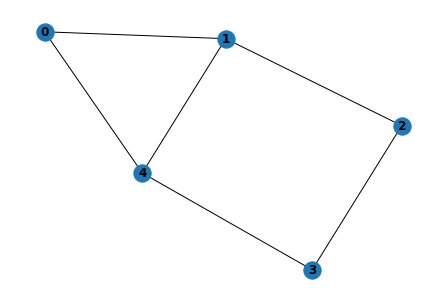

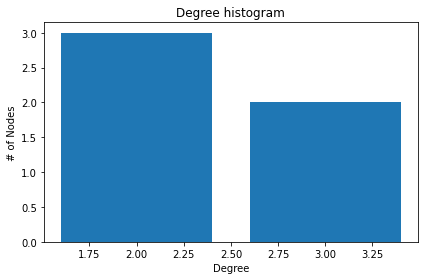

In [ ]:
# 1. n = 5 e m = 6
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger.info(df_output)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())

Distância inicial 26.0
Distância Final 26.0


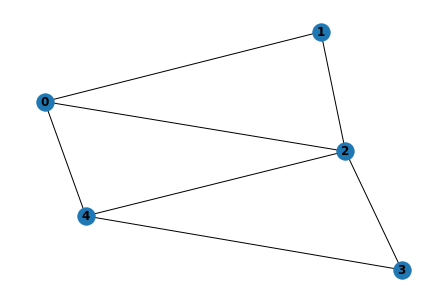

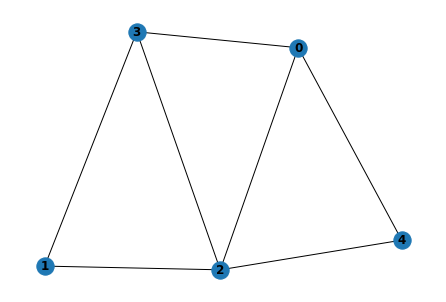

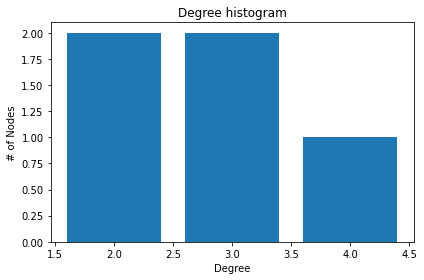

In [ ]:
# 2. n = 5 e m = 7
n = 5
m = 7
logger, visual_logger = create_logger("n5_m7")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())


Distância inicial 676.0
Distância Final 618.0


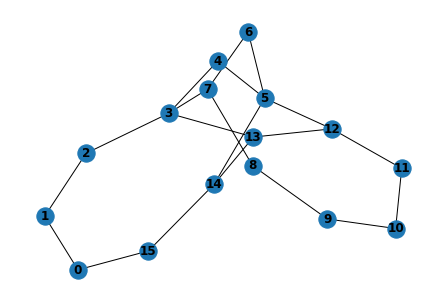

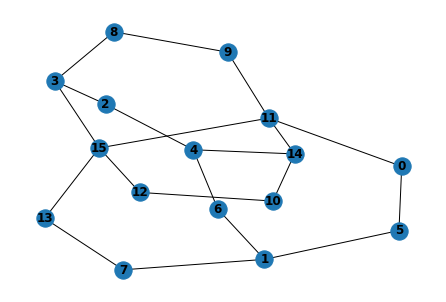

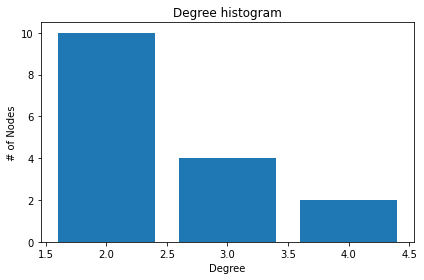

In [ ]:
# 3. n = 16 e m = 20
n = 16
m = 20
logger, visual_logger = create_logger("n16_m20")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())


Distância inicial 1318.0
Distância Final 1068.0


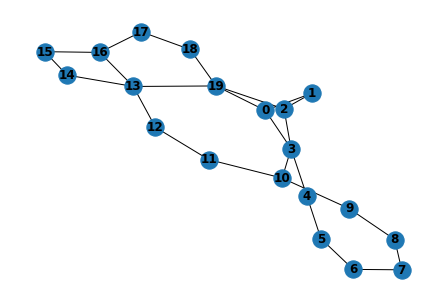

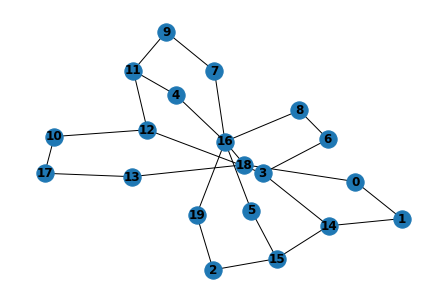

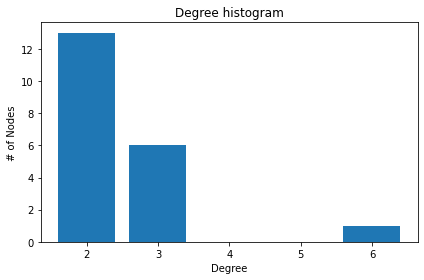

In [ ]:
# 4. n = 20 e m = 25
n = 20
m = 25
logger, visual_logger = create_logger("n20_m25")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger, 10000)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())

Distância inicial 3964.0
Distância Final 3196.0


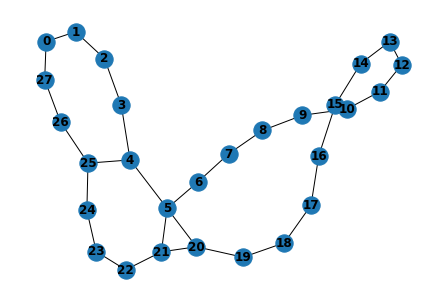

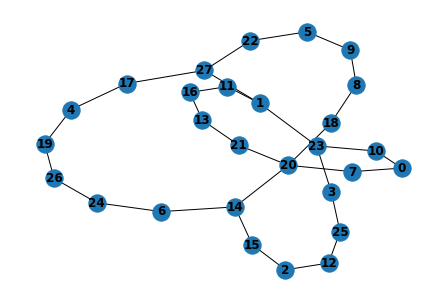

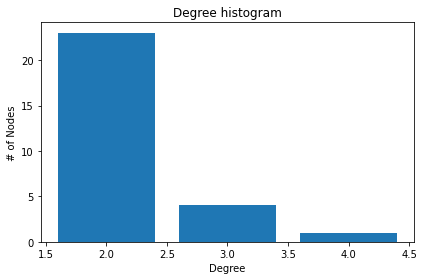

In [ ]:
# 5. n = 28 e m = 31
n = 28
m = 31
logger, visual_logger = create_logger("n28_m31")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())


Distância inicial 5140.0
Distância Final 4700.0


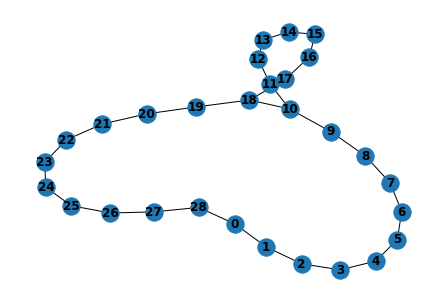

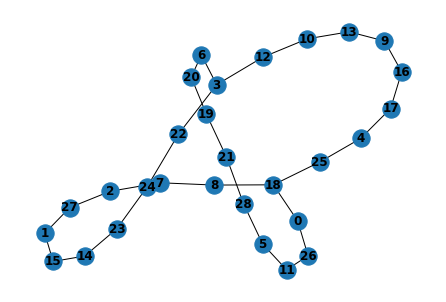

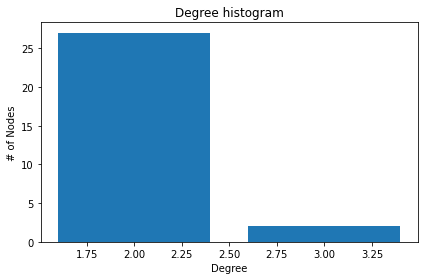

In [ ]:
# 6. n = 29 e m = 30
n = 29
m = 30
logger, visual_logger = create_logger("n29_m30")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())

Distância inicial 3012.0
Distância Final 2866.0


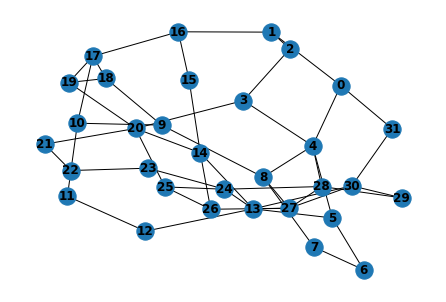

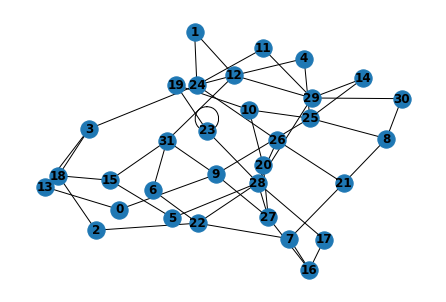

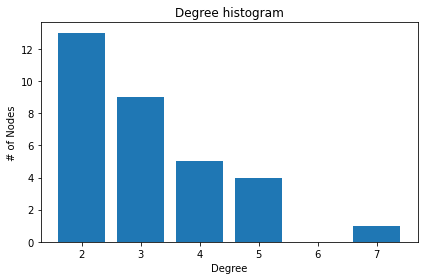

In [ ]:
# 7. n = 32 e m = 50
n = 32
m = 50
logger, visual_logger = create_logger("n32_m50")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())


Distância inicial 2678.0
Distância Final 2542.0


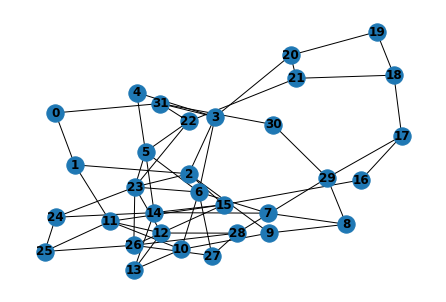

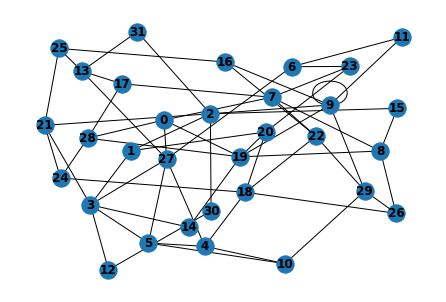

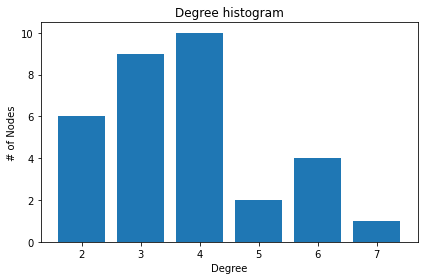

In [ ]:
# 8. n = 32 e m = 60
n = 32
m = 60
logger, visual_logger = create_logger("n32_m60")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())


# Cadeia de Markov Tempo Contínuo: Falhas e Reparos

In [11]:
# funções auxiliares
def confidence_interval(arr):
  z = 1.96

  std_err = np.std(arr)/np.sqrt(len(arr))
  media = np.mean(arr)
  
  return (media - z * std_err, media + z * std_err)

def get_edges(graph_matrix):
  '''
    Recebe a matriz do grafo e retorna uma lista de tuplas das arestas
  '''
  edges = []
  nodes = np.shape(graph_matrix)[0]
  for i in range(nodes):
    # só preciso checar a diagonal superior
    for j in range(i+1, nodes):
      if graph_matrix[i][j] == 1:
        edges.append((i, j))
  
  return edges

In [12]:
# variáveis globais
rounds = 10 # para calcular o intervalo de confiança

lam = 1 # lambda: taxa de falha (taxa de chegada do cliente)
mu = 1  # mu: taxa de reprado (taxa de atendimento ao cliente)


## Situação 1 (M/M/infinito)
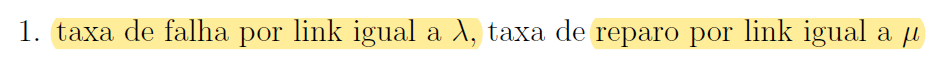

### Caso A
A. Tempo de reparo exponencialmente distribuído 

#### Sem agendamento

In [ ]:
def mm_infinite_a(graph_matrix, lam, mu, log, visual_log):
  '''
    TODO
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix)
  total_time = 10

  for i in range(rounds):
    # incialização das variáveis para um novo round
    graph = nx.from_numpy_matrix(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou
    
    disconnected_time = 0 # somo o tempo que estiver desconectado

    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho

    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação 

    # log 
    log.info(f"Comecei a rodada {i}")

    while time_passed <= total_time:
      fail = 0 # reseta valor
      repair = 0 # reseta valor
      log.info(f"Links funcionando {working}")
      log.info(f"Links quebrados {broken}")

      # escolhe o evento que vai rolar
      if len(broken) == 0: # caso em que todos os links funcionam, "preciso" que alguém quebre
        fail = np.random.exponential(scale=1/len(working)*lam, size=1)[0] # tempo de chegada é exponencialmente distribuido
        event = fail
      elif len(working) == 0:  # caso não tenha ninguém funcionando, "preciso" consertar
        repair = np.random.exponential(scale=1/len(broken)*mu, size=1)[0] 
        event = repair
      else: # caso em que tenho links quebrados e funcionando, assim preciso "ver" qual evento (falha ou reparo) vai rolar
        arrival = np.random.exponential(scale=1/len(working)*lam, size=1)[0] # tempo de chegada é exponencialmente distribuido
        repair = np.random.exponential(scale=1/len(broken)*mu, size=1)[0] # FIXME: 1/mu? size=waiting?
        clock = np.concatenate(([arrival], [repair])) # clock guarda o tempo de chegada e reparo
        event = np.min(clock) # vejo se nesse instante de tempo o que vai acontecer: mais um link quebrar ou o link ser consertado

      # atualiza o relógio
      prev_time = time_passed
      time_passed = time_passed + event

      # faz o evento acontecer: tira as arestas (quebra o link) ou colocoa (conserta)
      if event == fail: # significa que um link falhou
        log.info(f"O evento que vai rolar nesse isntante de tempo {time_passed} é uma falha")
        # sorteia a aresta/link que falhou
        link_idx = np.random.randint(0, len(working))
        # log
        log.info(f"O link {working[link_idx]} quebrou")
        # adiciona na lista de quebrados e atualiza lista de quem funciona
        broken.append(working[link_idx])
        working.pop(link_idx)
        # atualiza o grafo
        graph.remove_edge(broken[-1][0], broken[-1][1])

      else: # significa que um link foi reparado nesse instante de tempo
        log.info(f"O evento que vai rolar nesse isntante de tempo {time_passed} é um reparo")
        # conserto o primeiro link quebrado
        link = broken[0]
        # adiciona a lista de link funcional e retira da lista de quebrados
        working.append(link)
        broken.remove(link)
        # log
        log.info(f"O link {working[link_idx]} foi reparado")
        # atualiza o grafo, recolocando o link
        graph.add_edge(working[-1][0], working[-1][1])
  

      # arrumar métricas
      interval = time_passed - prev_time
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed)
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail




Distância inicial 28.0
Distância Final 28.0


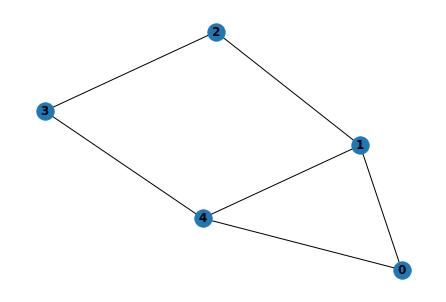

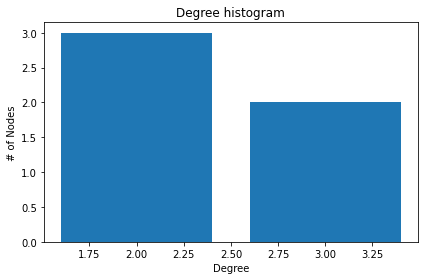

Tempo desconectado 0.0
Intervalo de confiança (0.0, 0.0)
Tempo com pelo menos um link falho 0.5039189128118615
Intervalo de confiança (0.47442415701424034, 0.5334136686094827)
Tempo conectado com pelo menos um link falho 0.5039189128118615
Intervalo de confiança (0.47442415701424034, 0.5334136686094827)


In [ ]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_inf_A_n5_m6")
disconnected, fail_link, connected_fail = mm_infinite_a(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 682.0
Distância Final 608.0


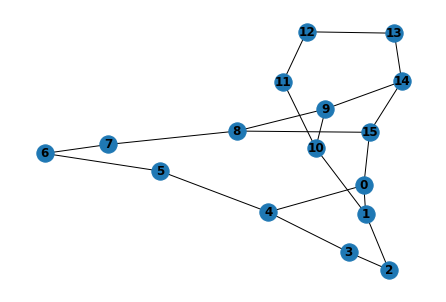

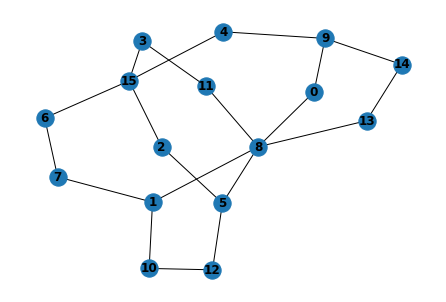

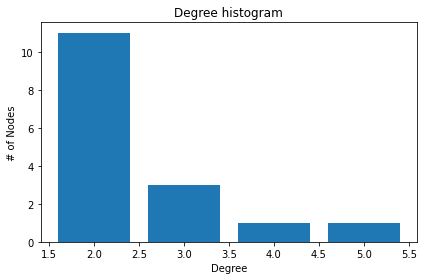

Tempo desconectado 0.0
Intervalo de confiança (0.0, 0.0)
Tempo com pelo menos um link falho 0.49664430325726006
Intervalo de confiança (0.46387396899112127, 0.5294146375233989)
Tempo conectado com pelo menos um link falho 0.49664430325726006
Intervalo de confiança (0.46387396899112127, 0.5294146375233989)


In [ ]:
n = 16
m = 20
logger, visual_logger = create_logger("n16_m20")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_inf_A_n16_m20")
disconnected, fail_link, connected_fail = mm_infinite_a(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

#### Com agendamento

##### Opção 1

- Faz o agendamento de falha de somente 1 link antes da simulação começar
- Sempre que tiver aresta disponível para quebrar, agenda a falha
- E quando quebrar uma aresta agenda o reparo

In [47]:
def mm_infinite_a_booking(graph_matrix, lam, mu, log, visual_log_sim):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix) # lista de tuplas. Ex: (1, 2) tenho uma ares que liga 1 a 2
  total_time = 100

  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    booked_events = [] # lista que vai possuir dicionários
                       # eventos vão ser ordenados pela instante de tempo que devem ocorrer

    graph = nx.from_numpy_matrix(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação
                           

    # log 
    log.info(f"Comecei a rodada {i}")
    # agendo uma falha para começar
    time = time_passed + np.random.exponential(1/(len(working)*lam))
    link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
    booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
    log.info(f"Agendo uma falha na aresta {working[link_idx]} no tempo {time} para começar")
    working.pop(link_idx)

    while time_passed <= total_time: # loop da simulação
      log.info(f"Lista de eventos agendados {booked_events}")

      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])
      
      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval
      
      time_passed = current_event['time']
      
      if current_event['type'] == fail:
        if len(working) > 0: # se ainda tiver links funcionando já agendo a próxima falha
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam)) # garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          # log no arquivo
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          # atualiza a lista de arestas funcionais
          working.pop(link_idx)
 
        # lido com a falha atual: de fato, quebrar o link (tirar do grafo, tirar da lista de funcionando...) e agendar o reparo

        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        time_passed = current_event['time']
        # colocando no log que quebrou o link
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")

        # agendado o reparo do link que acabou de ser quebrado
        time = current_event['time'] + np.random.exponential(1/mu)
        booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
        # colocando no log o agendamento do reparo
        log.info(f"Assim, preciso agendar o reparo de {current_event['link']} para o tempo {time}")

      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        working.append(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        time_passed = current_event['time']
        # log
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento está sendo feito o reparo do link {current_event['link']}")  
      
        # agendo mais falhas em qualquer link
        if len(working) > 0:
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam)) # garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          working.pop(link_idx)

      # atualiza a agenda de eventos
      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail


Distância inicial 28.0
Distância Final 28.0


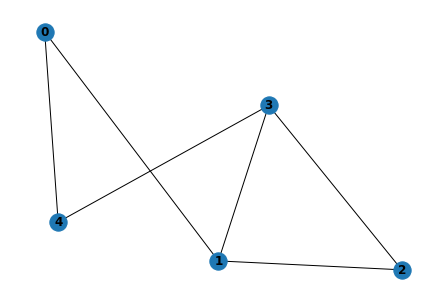

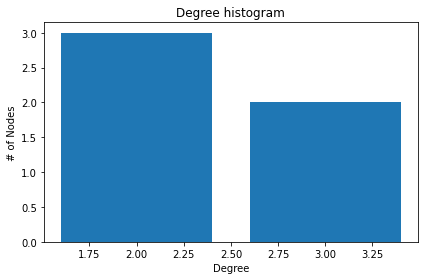

Tempo desconectado 0.7089649754147865
Intervalo de confiança (0.6839379479565143, 0.7339920028730588)
Tempo com pelo menos um link falho 0.9811144720537804
Intervalo de confiança (0.9762182033106357, 0.9860107407969252)
Tempo conectado com pelo menos um link falho 0.2721494966389938
Intervalo de confiança (0.251327480502246, 0.29297151277574157)


In [48]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n5_m6")
disconnected_inf_exp, fail_link_inf_exp, connected_fail_inf_exp = mm_infinite_a_booking(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected_inf_exp))
print("Intervalo de confiança", confidence_interval(disconnected_inf_exp))
print("Tempo com pelo menos um link falho", np.mean(fail_link_inf_exp))
print("Intervalo de confiança", confidence_interval(fail_link_inf_exp))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail_inf_exp))
print("Intervalo de confiança", confidence_interval(connected_fail_inf_exp))

##### Opção 2
- Faz o agendamento de todas as falhas antes da simulação começar
- Quando um link quebra já agendo seu reparo
- Quando um link é reparado já agendo uma nova falha para ele

In [55]:
def mm_infinite_a_booking_alt(graph_matrix, lam, mu, log, visual_log_sim):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix) # lista de tuplas. Ex: (1, 2) tenho uma ares que liga 1 a 2
  total_time = 100
  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    booked_events = [] # lista que vai possuir dicionários
                       # eventos vão ser ordenados pela instante de tempo que devem ocorrer

    graph = nx.Graph(graph_matrix)
    # graph = nx.from_numpy_matrix(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação
                           

    # log 
    log.info(f"Comecei a rodada {i}")
    # agendo todoas as falhas
    log.info(f"Iniciando agendando todas as falhas")
    for link in working:
      time = np.random.exponential(1/lam)
      booked_events.append({'type': fail, 'time': time, 'link': link})
    
    booked_events = sorted(booked_events, key=lambda d: d['time'])

    while time_passed <= total_time: # loop da simulação
      log.info(f"Lista de eventos agendados {booked_events}")

      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])
      
      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval

      time_passed = current_event['time']
      if current_event['type'] == fail:
        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        # colocando no log que quebrou o link
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")

        # agendado o reparo do link que acabou de ser quebrado
        time = current_event['time'] + np.random.exponential(1/mu)
        booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
        # colocando no log o agendamento do reparo
        log.info(f"Assim, preciso agendar o reparo de {current_event['link']} para o tempo {time}")

      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        # log
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento está sendo feito o reparo do link {current_event['link']}") 
        # marco a quebra dessa aresta
        log.info(f"Assim agendo a próxima falha do {current_event['link']}") 
        time = current_event['time'] + np.random.exponential(1/lam)
        booked_events.append({'type': fail, 'time': time, 'link': current_event['link']})
        

      # ao final tiro o primeiro evento da lista
      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail

Distância inicial 28.0
Distância Final 28.0


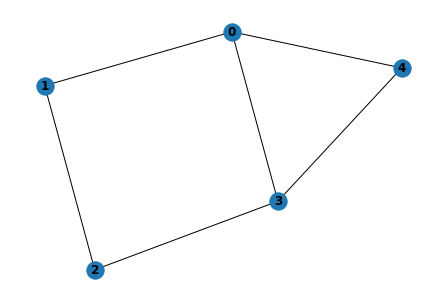

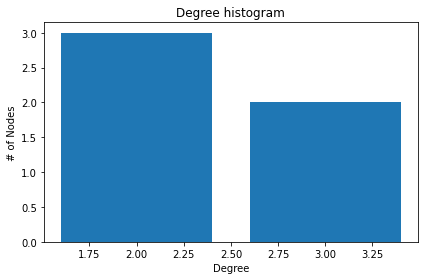

Tempo desconectado 0.709381445550313
Intervalo de confiança (0.6886261763510574, 0.7301367147495686)
Tempo com pelo menos um link falho 0.9800828175509796
Intervalo de confiança (0.9734042188438078, 0.9867614162581514)
Tempo conectado com pelo menos um link falho 0.27070137200066646
Intervalo de confiança (0.2531018011899771, 0.2883009428113558)


In [50]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n5_m6")
disconnected_inf_exp, fail_link_inf_exp, connected_fail_inf_exp = mm_infinite_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected_inf_exp))
print("Intervalo de confiança", confidence_interval(disconnected_inf_exp))
print("Tempo com pelo menos um link falho", np.mean(fail_link_inf_exp))
print("Intervalo de confiança", confidence_interval(fail_link_inf_exp))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail_inf_exp))
print("Intervalo de confiança", confidence_interval(connected_fail_inf_exp))

Distância inicial 660.0
Distância Final 594.0


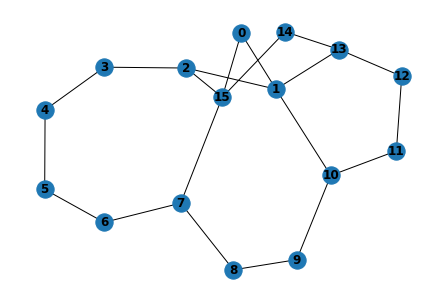

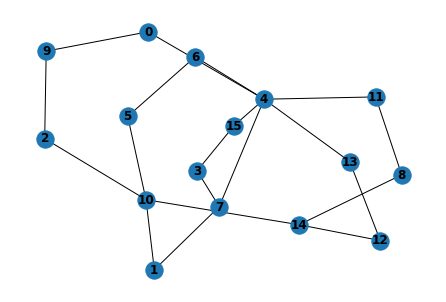

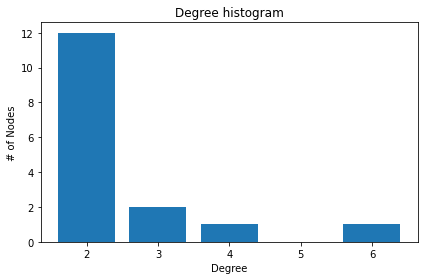

Tempo desconectado 0.9921925038830347
Intervalo de confiança (0.9898118110433312, 0.9945731967227383)
Tempo com pelo menos um link falho 0.9994424783598752
Intervalo de confiança (0.9991686730410246, 0.9997162836787258)
Tempo conectado com pelo menos um link falho 0.007249974476840561
Intervalo de confiança (0.004965417342517819, 0.009534531611163303)


In [51]:
n = 16
m = 20
logger, visual_logger = create_logger("n16_20")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n16_m20")
disconnected, fail_link, connected_fail = mm_infinite_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 1334.0
Distância Final 1092.0


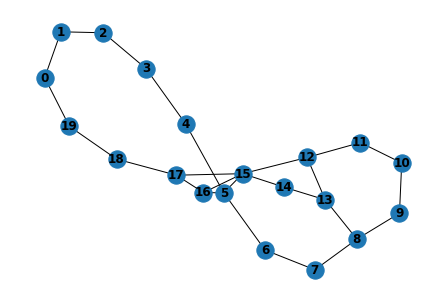

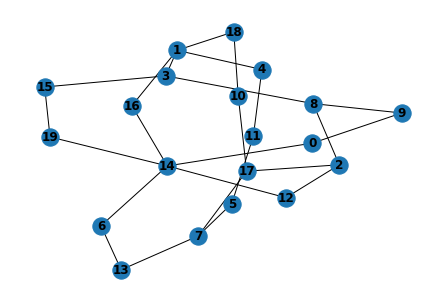

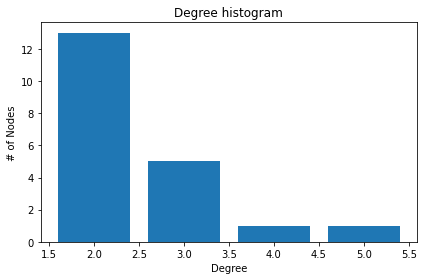

Tempo desconectado 0.994553989844813
Intervalo de confiança (0.9926553440006348, 0.9964526356889912)
Tempo com pelo menos um link falho 0.9996978392019281
Intervalo de confiança (0.9995381819417152, 0.9998574964621411)
Tempo conectado com pelo menos um link falho 0.005143849357115013
Intervalo de confiança (0.0033412478669239574, 0.006946450847306068)


In [52]:
n = 20
m = 25
logger, visual_logger = create_logger("n20_m25")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n20_m25")
disconnected, fail_link, connected_fail = mm_infinite_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 5752.0
Distância Final 4700.0


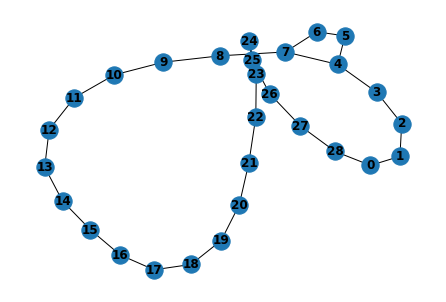

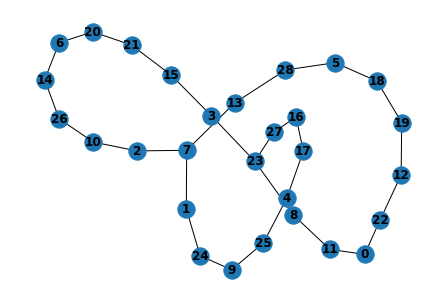

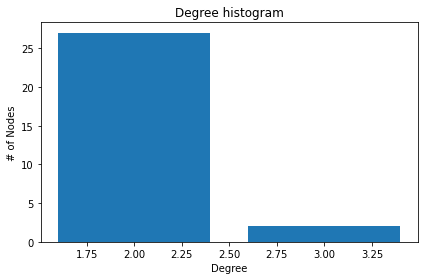

Tempo desconectado 0.9991814126523495
Intervalo de confiança (0.9989166373207936, 0.9994461879839054)
Tempo com pelo menos um link falho 0.9996600245124501
Intervalo de confiança (0.9994557897385556, 0.9998642592863445)
Tempo conectado com pelo menos um link falho 0.000478611860100609
Intervalo de confiança (0.00024551857182770326, 0.0007117051483735147)


In [53]:
n = 29
m = 30
logger, visual_logger = create_logger("n29_m30")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n29_m30")
disconnected, fail_link, connected_fail = mm_infinite_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 3068.0
Distância Final 2828.0


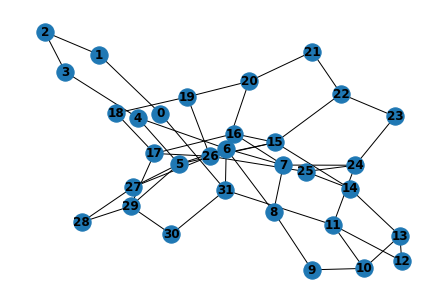

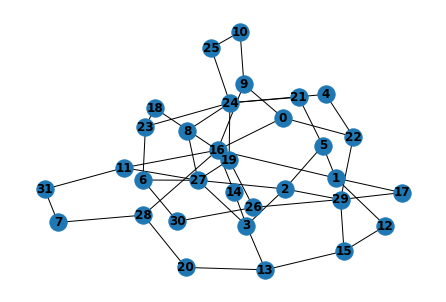

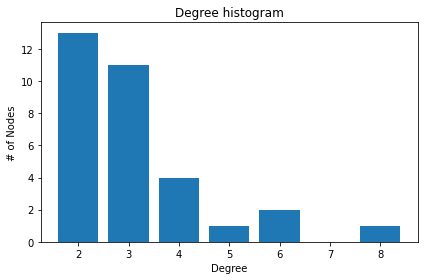

Tempo desconectado 0.9958044488263902
Intervalo de confiança (0.9941331123435505, 0.9974757853092299)
Tempo com pelo menos um link falho 0.9998188886416924
Intervalo de confiança (0.9997314506511531, 0.9999063266322318)
Tempo conectado com pelo menos um link falho 0.004014439815302115
Intervalo de confiança (0.0023732976412985576, 0.005655581989305672)


In [54]:
n = 32
m = 50
logger, visual_logger = create_logger("n32_50")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n32_m50")
disconnected, fail_link, connected_fail = mm_infinite_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

### Caso B
B. Tempo de reparo distribuído de forma determinística


#### Opção 1
- Faz o agendamento de falha de somente 1 link antes da simulação começar
- Sempre que tiver aresta disponível para quebrar, agenda a falha
- E quando quebrar uma aresta agenda o reparo

In [56]:
def mm_infinite_b(graph_matrix, lam, mu, log, visual_log):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix)
  total_time = 1000

  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    booked_events = [] # lista que vai possuir dicionários
                       # eventos võa ser ordenados pela instante de tempo que devem ocorrer

    graph = nx.Graph(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou
    time_stamp = 0 # tempo de ocorrência de eventos

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação 
    
    # mensagem no arquivo de log
    log.info(f"Comecei a rodada {i}") 
    log.info(f"Agendo uma falha para começar") 
    # agendo uma falha para começar
    time = time_passed + np.random.exponential(1/(len(working)*lam))
    link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
    booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
    working.pop(link_idx)

    while time_passed <= total_time:
      log.info(f"Lista de eventos agendados {booked_events}")

      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])
      
      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval

      time_passed = current_event['time']

      if current_event['type'] == fail:
        if len(working) > 0: # se ainda tiver links funcionando já agendo a próxima falha
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam)) # garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          # log no arquivo
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          # atualizo as arestas disponíveis para quebrar (os links funcionando)
          working.pop(link_idx)
 
        # lido com a falha atual: de fato, quebrar o link (tirar do grafo, tirar da lista de funcionando...) e agendar o reparo

        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        time_passed = current_event['time']
        # colocando no log que quebrou o link
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")
        
        # agendado o reparo do link que acabou de ser quebrado
        time = current_event['time'] + 1/mu
        booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
        # colocando no log o agendamento do reparo
        log.info(f"Assim, agendei o reparo de {current_event['link']} para o tempo {time}")


      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        working.append(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        time_passed = current_event['time']
        # log
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento está sendo feito o reparo do link {current_event['link']}") 
        # agendo uma falha no caso de ter links disponíveis
        if len(working) > 0:
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam)) # garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          working.pop(link_idx)
      

      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail

Distância inicial 28.0
Distância Final 28.0


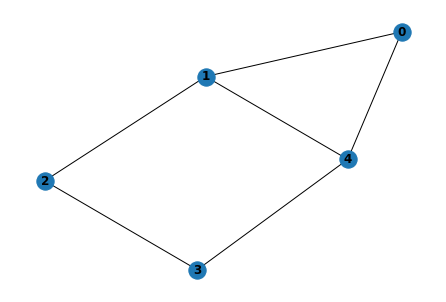

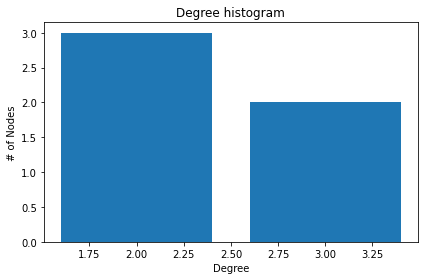

Tempo desconectado 0.7197610246766353
Intervalo de confiança (0.7154986979687, 0.7240233513845705)
Tempo com pelo menos um link falho 0.9839543807914268
Intervalo de confiança (0.9827757562766238, 0.9851330053062298)
Tempo conectado com pelo menos um link falho 0.2641933561147914
Intervalo de confiança (0.26052198299137613, 0.26786472923820664)


In [97]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_A_book_n5_m6")
disconnected, fail_link, connected_fail = mm_infinite_b(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

#### Opção 2
- Faz o agendamento de todas as falhas antes da simulação começar
- Quando um link quebra já agendo seu reparo
- Quando um link é reparado já agendo uma nova falha para ele

In [57]:
def mm_infinite_b_alt(graph_matrix, lam, mu, log, visual_log):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix)
  total_time = 100

  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    booked_events = [] # lista que vai possuir dicionários
                       # eventos võa ser ordenados pela instante de tempo que devem ocorrer

    graph = nx.from_numpy_matrix(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação 
    
    # mensagem no arquivo de log
    log.info(f"Comecei a rodada {i}") 
    log.info(f"Agendo todas as falhas")
    # agendamento de todas as falhas
    for link in working:
      time = np.random.exponential(1/lam)
      booked_events.append({'type': fail, 'time': time, 'link': link})
    
    # ordenação dos eventos de falha de acordo com o timestamp
    booked_events = sorted(booked_events, key=lambda d: d['time'])

    while time_passed <= total_time:
      log.info(f"Lista de eventos agendados {booked_events}")
      
      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])
      
      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval
      
      time_passed = current_event['time']
      if current_event['type'] == fail:
        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        time_passed = current_event['time']
        # colocando no log que quebrou o link
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")
        
        # agendado o reparo do link que acabou de ser quebrado
        time = current_event['time'] + 1/mu
        booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
        # colocando no log o agendamento do reparo
        log.info(f"Assim, agendei o reparo de {current_event['link']} para o tempo {time}")
      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        # log
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento está sendo feito o reparo do link {current_event['link']}") 
        # marco a quebra dessa mesma aresta
        time = current_event['time'] + np.random.exponential(1/lam)
        booked_events.append({'type': fail, 'time': time, 'link': current_event['link']})
        log.info(f"Assim, marco a quebra desse link {current_event['link']}")

      # atualizo a agenda de eventos
      # ao final, tiro o primeiro evento da lista
      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])
    
      
    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail

Distância inicial 28.0
Distância Final 28.0


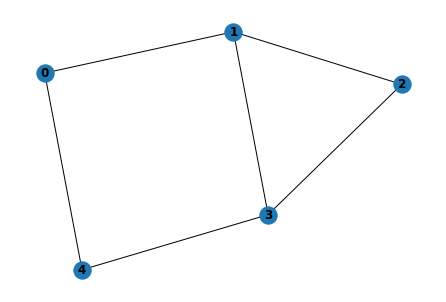

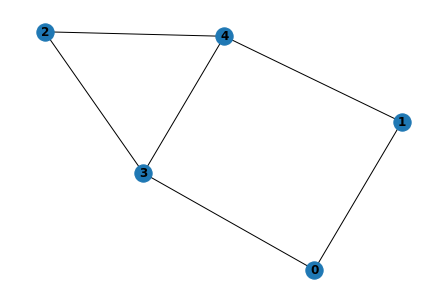

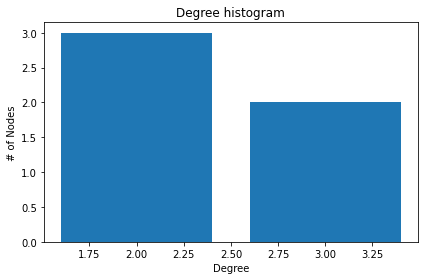

Tempo desconectado 0.7168496690047323
Intervalo de confiança (0.7037347740444105, 0.7299645639650542)
Tempo com pelo menos um link falho 0.9835093028336684
Intervalo de confiança (0.9794079560220171, 0.9876106496453197)
Tempo conectado com pelo menos um link falho 0.2666596338289363
Intervalo de confiança (0.2551100154988857, 0.27820925215898695)


In [23]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_inf_B_n5_m6")
disconnected_1_det, fail_link_1_det, connected_fail_1_det = mm_infinite_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected_1_det))
print("Intervalo de confiança", confidence_interval(disconnected_1_det))
print("Tempo com pelo menos um link falho", np.mean(fail_link_1_det))
print("Intervalo de confiança", confidence_interval(fail_link_1_det))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail_1_det))
print("Intervalo de confiança", confidence_interval(connected_fail_1_det))

Distância inicial 640.0
Distância Final 598.0


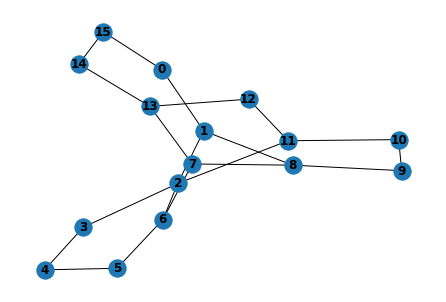

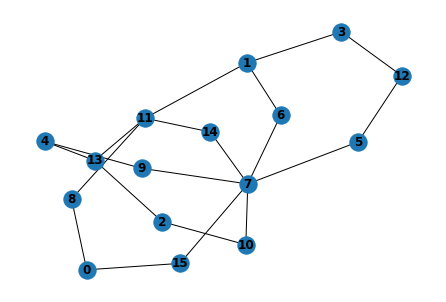

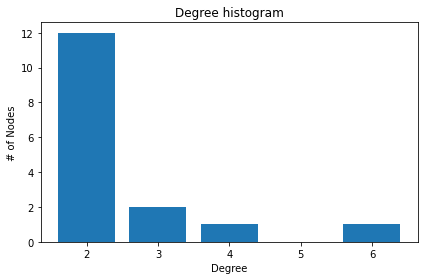

Tempo desconectado 0.9921621019065776
Intervalo de confiança (0.9906349028937164, 0.9936893009194389)
Tempo com pelo menos um link falho 0.9992347968380907
Intervalo de confiança (0.9988070855341427, 0.9996625081420387)
Tempo conectado com pelo menos um link falho 0.00707269493151298
Intervalo de confiança (0.005500998675418984, 0.008644391187606975)


In [25]:
n = 16
m = 20
logger, visual_logger = create_logger("n16_20")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_inf_B_n16_m20")
disconnected, fail_link, connected_fail = mm_infinite_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 1196.0
Distância Final 1070.0


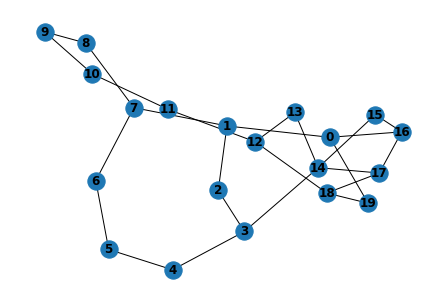

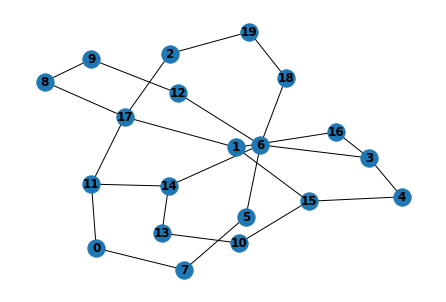

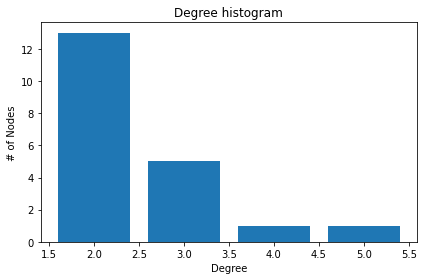

Tempo desconectado 0.9961668062660595
Intervalo de confiança (0.9949341655231748, 0.9973994470089441)
Tempo com pelo menos um link falho 0.9996343719676044
Intervalo de confiança (0.9994450755094858, 0.999823668425723)
Tempo conectado com pelo menos um link falho 0.003467565701544837
Intervalo de confiança (0.0023725625752949414, 0.004562568827794733)


In [26]:
n = 20
m = 25
logger, visual_logger = create_logger("n20_m25")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_inf_B_n20_m25")
disconnected, fail_link, connected_fail = mm_infinite_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 5752.0
Distância Final 4700.0


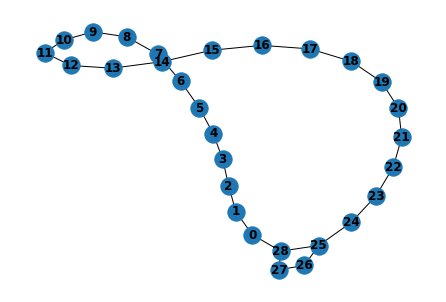

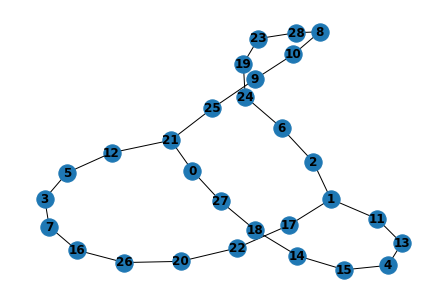

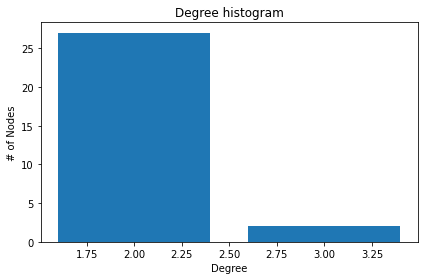

Tempo desconectado 0.999283869661513
Intervalo de confiança (0.9990140762769087, 0.9995536630461171)
Tempo com pelo menos um link falho 0.9998113272190032
Intervalo de confiança (0.9997361337256554, 0.9998865207123511)
Tempo conectado com pelo menos um link falho 0.0005274575574903092
Intervalo de confiança (0.0002950250299032393, 0.000759890085077379)


In [31]:
n = 29
m = 30
logger, visual_logger = create_logger("n29_m30")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n29_m30")
disconnected, fail_link, connected_fail = mm_infinite_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 3202.0
Distância Final 2878.0


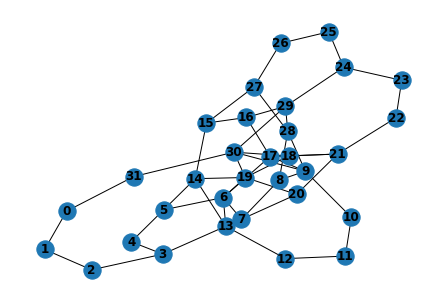

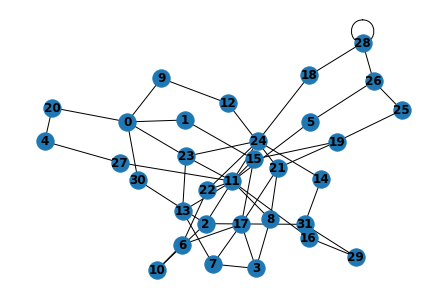

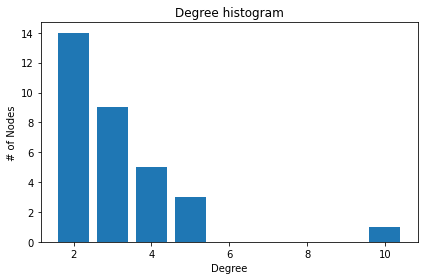

Tempo desconectado 0.9975191491203997
Intervalo de confiança (0.9968576140547275, 0.998180684186072)
Tempo com pelo menos um link falho 0.9996668000507027
Intervalo de confiança (0.9995257387490958, 0.9998078613523097)
Tempo conectado com pelo menos um link falho 0.002147650930302887
Intervalo de confiança (0.0014728291844260163, 0.0028224726761797575)


In [29]:
n = 32
m = 50
logger, visual_logger = create_logger("n32_m50")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_inf_B_n32_m50")
disconnected, fail_link, connected_fail = mm_infinite_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

## Situação 2 (M/M/1)
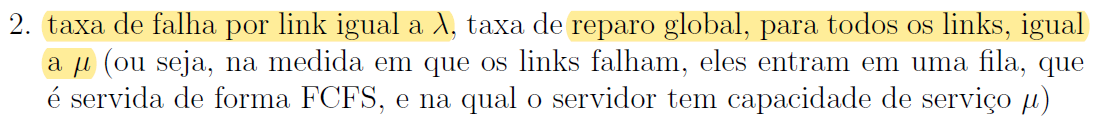

### Caso A
Tempo de reparo exponencialmente distribuído

#### Opção 1
- Faz o agendamento de falha de somente 1 link antes da simulação começar
- Sempre que tiver aresta disponível para quebrar, agenda a falha
- E quando quebrar uma aresta agenda o reparo

In [77]:
def mm_one_a_booking(graph_matrix, lam, mu, log, visual_log):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix)
  total_time = 100

  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    waiting = [] # lista para guardar a fila da arestas quebradas, mas que não entraram na fila de eventos
                 # no caso da M/M/1 só posso ter um evento de reparo na fila de eventos
    booked_events = [] # lista que vai possuir dicionários
                       # eventos võa ser ordenados pela instante de tempo que devem ocorrer

    
    graph = nx.Graph(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação 

    # log
    log.info(f"Comecei a rodada {i}")
    # agendo uma falha para começar
    
    log.info(f"Agendo uma falha na aresta {working[link_idx]} no tempo {time} para começar")
    time = np.random.exponential(1/(len(working)*lam))
    link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
    booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
    working.pop(link_idx)

    while time_passed <= total_time:
      log.info(f"Lista de eventos agendados {booked_events}")
      log.info(f"Lista de espera de reparos {waiting}")

      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])
      
      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval

      time_passed = current_event['time']

      if current_event['type'] == fail:
        if len(working) > 0: # se ainda tiver links funcionando já agendo a próxima falha
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam))# garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          # log no arquivo
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          working.pop(link_idx)
 
        # lido com a falha atual: de fato, quebrar o link (tirar do grafo, tirar da lista de funcionando...) e agendar o reparo

        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")

        # agendado o reparo do link que acabou de ser quebrado
        # por ser uma M/M/1 preciso checar se já não tenho alguém na fila para ser reparado
        # se tiver coloco na lista de waiting
        if len([element for element in booked_events if element['type'] == repair]) == 0: # não tenho repair nos eventos agendados, coloco
          time = current_event['time'] + np.random.exponential(1/mu)
          booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
          log.info(f"Como não tenho reparos agendados, agendo o reparo do link {current_event['link']} para o tempo {time}")
        else: 
          waiting.append(current_event['link']) # coloco em waiting a aresta que precisa ser arrumada
          log.info(f"Como tenho reparos agendados, agendo o reparo do link {current_event['link']} na última poisção da fila de espera {waiting}")

      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        working.append(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} foi reparado")
        if len(waiting) > 0:  # se tiver alguém esperando seu lugar ao sol, pego a primeira aresta e agendo nos eventos
          time = current_event['time'] + np.random.exponential(1/mu)
          booked_events.append({'type': repair, 'time': time, 'link': waiting[0]})
          log.info(f"Como reparei uma aresta e tirei ela da lista de eventos, agendo o conserto da primeira aresta da fila, o link {waiting[0]} vai para fila e vai ocorrer no tempo {time}")
          waiting.pop(0)
        
        if len(working) > 0: # tenod gente funcionando adiciono uma nova falha
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam))# garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          # log no arquivo
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          working.pop(link_idx)
      
      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])
    

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail

Distância inicial 28.0
Distância Final 28.0


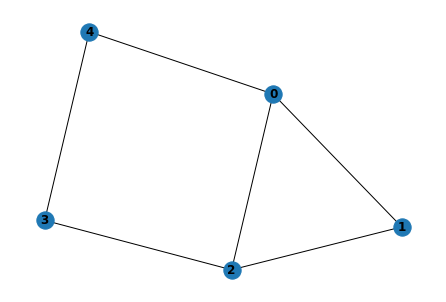

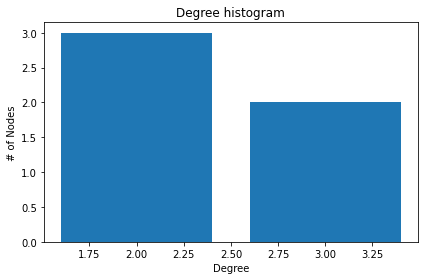

Tempo desconectado 0.9752940737234539
Intervalo de confiança (0.9668323154706381, 0.9837558319762697)
Tempo com pelo menos um link falho 0.9966694395924023
Intervalo de confiança (0.9953605692913905, 0.9979783098934141)
Tempo conectado com pelo menos um link falho 0.021375365868948303
Intervalo de confiança (0.013817357243262158, 0.02893337449463445)


In [78]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_A_book_n5_m6")
disconnected, fail_link, connected_fail = mm_one_a_booking(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

#### Opção 2
- Faz o agendamento de todas as falhas antes da simulação começar
- Quando um link quebra já agendo seu reparo
- Quando um link é reparado já agendo uma nova falha para ele

In [58]:
def mm_one_a_booking_alt(graph_matrix, lam, mu, log, visual_log):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix)
  total_time = 100

  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    waiting = [] # lista para guardar a fila da arestas quebradas, mas que não entraram na fila de eventos
                 # no caso da M/M/1 só posso ter um evento de reparo na fila de eventos
    booked_events = [] # lista que vai possuir dicionários
                       # eventos võa ser ordenados pela instante de tempo que devem ocorrer

    
    graph = nx.Graph(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação 

    # log
    log.info(f"Comecei a rodada {i}")
    log.info(f"Iniciando agendando todas as falhas")
    # agendo todoas as falhas
    for link in working:
      time = np.random.exponential(1/lam)
      booked_events.append({'type': fail, 'time': time, 'link': link})
      # working.remove(link)

    booked_events = sorted(booked_events, key=lambda d: d['time'])

    while time_passed <= total_time:
      log.info(f"Lista de eventos agendados {booked_events}")
      log.info(f"Lista de espera de reparos {waiting}")
        
      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])

      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval
      
      time_passed = current_event['time']

      if current_event['type'] == fail:
 
        # lido com a falha atual: de fato, quebrar o link (tirar do grafo, tirar da lista de funcionando...) e agendar o reparo

        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")

        # agendado o reparo do link que acabou de ser quebrado
        # por ser uma M/M/1 preciso checar se já não tenho alguém na fila para ser reparado
        # se tiver coloco na lista de waiting
        if len([element for element in booked_events if element['type'] == repair]) == 0: # não tenho repair nos eventos agendados, coloco
          time = current_event['time'] + np.random.exponential(1/mu)
          booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
          log.info(f"Como não tenho reparos agendados, agendo o reparo do link {current_event['link']} para o tempo {time}")
        else: 
          waiting.append(current_event['link']) # coloco em waiting a aresta que precisa ser arrumada
          log.info(f"Como tenho reparos agendados, agendo o reparo do link {current_event['link']} na última poisção da fila de espera {waiting}")


      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} foi reparado")
        if len(waiting) > 0:  # se tiver alguém esperando seu lugar ao sol, pego a primeira aresta e agendo nos eventos
          time = current_event['time'] + np.random.exponential(1/mu)
          booked_events.append({'type': repair, 'time': time, 'link': waiting[0]})
          log.info(f"Como reparei uma aresta e tirei ela da lista de eventos, agendo o conserto da primeira aresta da fila, o link {waiting[0]} vai para fila e vai ocorrer no tempo {time}")
          waiting.pop(0)
        # marcando a quebra da aresta
        log.info(f"Assim agendo a próxima falha do {current_event['link']}") 
        time = current_event['time'] + np.random.exponential(1/lam)
        booked_events.append({'type': fail, 'time': time, 'link': current_event['link']})

      # quando o agendamento do reparo é feito, preciso tirar o evento da minha lista
      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])
    

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail

Distância inicial 28.0
Distância Final 28.0


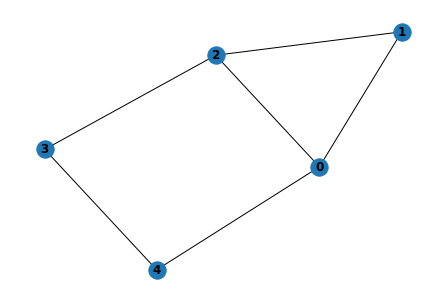

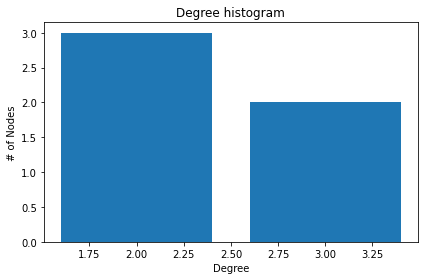

Tempo desconectado 0.9826249969455054
Intervalo de confiança (0.9769340321488297, 0.9883159617421812)
Tempo com pelo menos um link falho 0.9972553986339824
Intervalo de confiança (0.9954139884350381, 0.9990968088329266)
Tempo conectado com pelo menos um link falho 0.014630401688476949
Intervalo de confiança (0.009381267531672928, 0.019879535845280967)


In [37]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_A_book_n5_m6")
disconnected, fail_link, connected_fail = mm_one_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 748.0
Distância Final 610.0


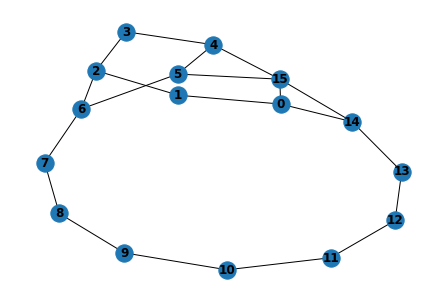

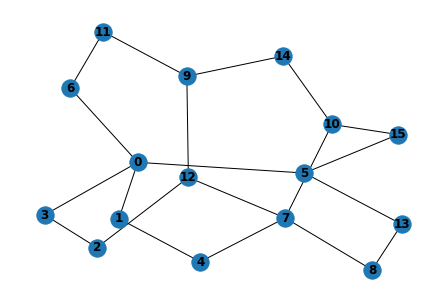

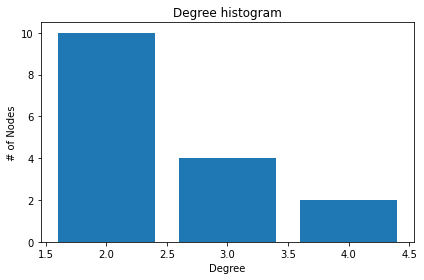

Tempo desconectado 0.9970979407650541
Intervalo de confiança (0.995944690410624, 0.9982511911194842)
Tempo com pelo menos um link falho 0.9993764705252319
Intervalo de confiança (0.9989614503816802, 0.9997914906687837)
Tempo conectado com pelo menos um link falho 0.0022785297601777667
Intervalo de confiança (0.0014194670814485734, 0.00313759243890696)


In [35]:
n = 16
m = 20
logger, visual_logger = create_logger("n16_m20")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_A_book_n16_m20")
disconnected, fail_link, connected_fail = mm_one_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 1272.0
Distância Final 1114.0


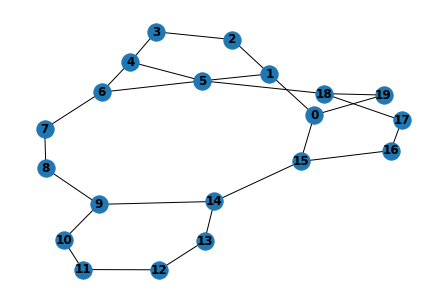

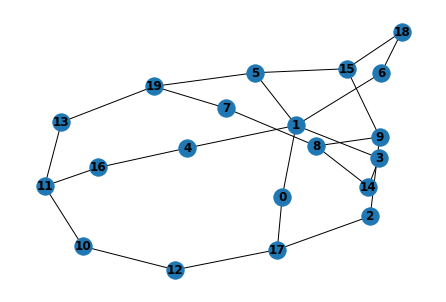

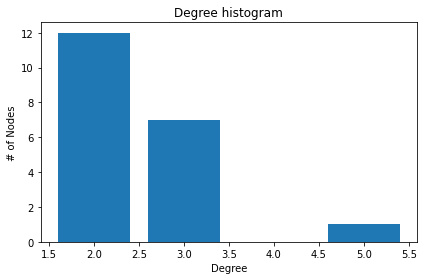

Tempo desconectado 0.9981636084138608
Intervalo de confiança (0.9975882556569183, 0.9987389611708032)
Tempo com pelo menos um link falho 0.999843206931774
Intervalo de confiança (0.9996901996493803, 0.9999962142141676)
Tempo conectado com pelo menos um link falho 0.0016795985179132917
Intervalo de confiança (0.001122723333357805, 0.0022364737024687786)


In [34]:
n = 20
m = 25
logger, visual_logger = create_logger("n20_m25")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_A_book_n20_m25")
disconnected, fail_link, connected_fail = mm_one_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 5468.0
Distância Final 4700.0


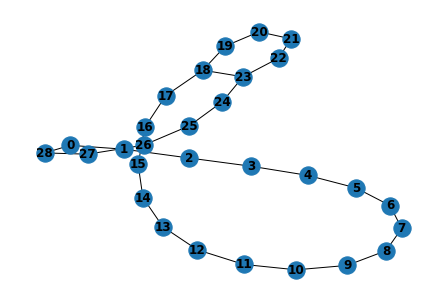

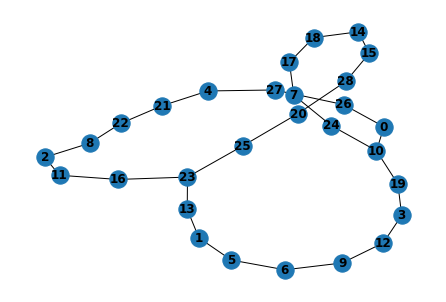

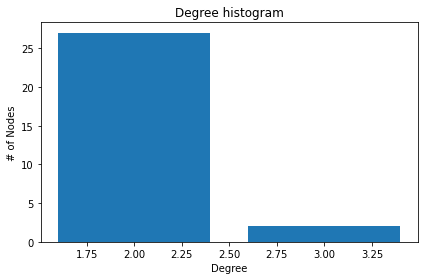

Tempo desconectado 0.9988486694977722
Intervalo de confiança (0.9985039447015855, 0.9991933942939588)
Tempo com pelo menos um link falho 0.9995371149152114
Intervalo de confiança (0.9992896254848732, 0.9997846043455495)
Tempo conectado com pelo menos um link falho 0.0006884454174391752
Intervalo de confiança (0.0004723626687342297, 0.0009045281661441207)


In [36]:
n = 29
m = 30
logger, visual_logger = create_logger("n29_m30")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n29_m30")
disconnected, fail_link, connected_fail = mm_one_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 2996.0
Distância Final 2800.0


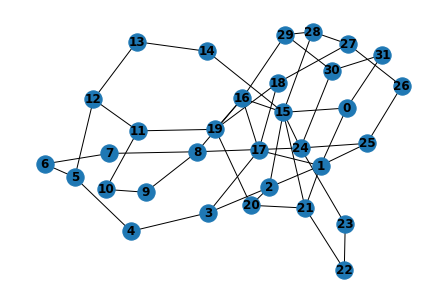

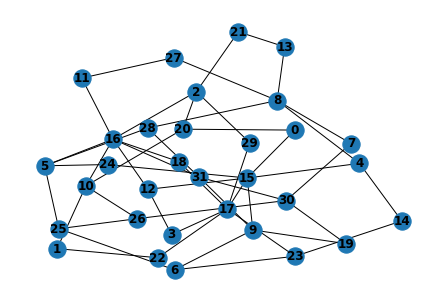

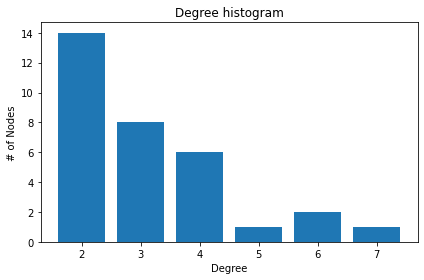

Tempo desconectado 0.997907523428605
Intervalo de confiança (0.9973441171338445, 0.9984709297233655)
Tempo com pelo menos um link falho 0.9998720304619632
Intervalo de confiança (0.9997892840791489, 0.9999547768447774)
Tempo conectado com pelo menos um link falho 0.001964507033358163
Intervalo de confiança (0.0014349095035179542, 0.0024941045631983716)


In [33]:
n = 32
m = 50
logger, visual_logger = create_logger("n32_m50")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_A_book_n32_m50")
disconnected, fail_link, connected_fail = mm_one_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 28.0
Distância Final 28.0


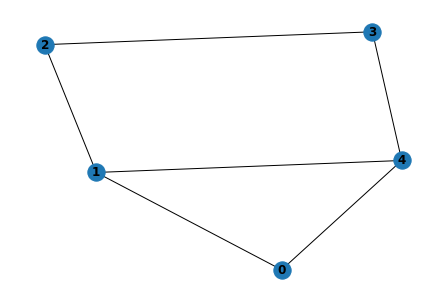

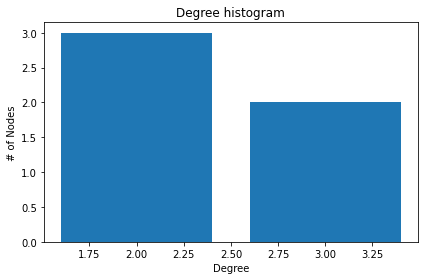

Tempo desconectado 0.9810385194060484
Intervalo de confiança (0.9740498611164055, 0.9880271776956913)
Tempo com pelo menos um link falho 0.9988328998990953
Intervalo de confiança (0.9982291567166199, 0.9994366430815707)
Tempo conectado com pelo menos um link falho 0.017794380493046963
Intervalo de confiança (0.01066376878252516, 0.024924992203568766)


In [49]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_A_book_n5_m6")
disconnected, fail_link, connected_fail = mm_one_a_booking_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

### Caso B
Tempo de reparo distribuído de forma determinística

#### Opção 1
- Faz o agendamento de falha de somente 1 link antes da simulação começar
- Sempre que tiver aresta disponível para quebrar, agenda a falha
- E quando quebrar uma aresta agenda o reparo

In [85]:
def mm_one_b(graph_matrix, lam, mu, log, visual_log):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix)
  total_time = 1000

  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    waiting = [] # lista para guardar a fila da arestas quebradas, mas que não entraram na fila de eventos
                 # no caso da M/M/1 só posso ter um evento de reparo na fila de eventos
    booked_events = [] # lista que vai possuir dicionários
                       # eventos võa ser ordenados pela instante de tempo que devem ocorrer

    graph = nx.from_numpy_matrix(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou
    time_stamp = 0 # tempo de ocorrência de eventos

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação 
    
    # log
    log.info(f"Comecei a rodada {i}")

    # Agendo uma falha
    time = time_passed + np.random.exponential(scale=1/(len(working)*lam), size=1)[0]
    link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
    booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
    log.info(f"Agendo uma falha na aresta {working[link_idx]} no tempo {time} para começar")
    working.pop(link_idx)

    while time_passed <= total_time:
      log.info(f"Lista de eventos agendados {booked_events}")
      log.info(f"Lista de espera de reparos {waiting}")

      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])
      
      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval

      time_passed  = current_event['time']

      if current_event['type'] == fail:
        if len(working) > 0: # se ainda tiver links funcionando já agendo a próxima falha
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam)) # garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          # log no arquivo
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          # atualiza as arestas que funcionam
          working.pop(link_idx)
 
        # lido com a falha atual: de fato, quebrar o link (tirar do grafo, tirar da lista de funcionando...) e agendar o reparo

        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")
        
        # agendado o reparo do link que acabou de ser quebrado
        # por ser uma M/M/1 preciso checar se já não tenho alguém na fila para ser reparado
        # se tiver coloco na lista de waiting
        if len([element for element in booked_events if element['type'] == repair]) <= 0: # não tenho repair nos eventos agendados, coloco
          time = current_event['time'] + 1/mu
          booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
          log.info(f"Como não tenho reparos agendados, agendo o reparo do link {current_event['link']} para o tempo {time}")
        else: 
          waiting.append(current_event['link']) # coloco em waiting a aresta que precisa ser arrumada
          log.info(f"Como tenho reparos agendados, agendo o reparo do link {current_event['link']} na última poisção da fila de espera {waiting}")


      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        working.append(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        time_passed = current_event['time']
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} foi reparado")
        if len(waiting) > 0:  # se tiver alguém esperando seu lugar ao sol, pego a primeira aresta e agendo nos eventos
          time = current_event['time'] + 1/mu
          booked_events.append({'type': repair, 'time': time, 'link': waiting[0]})
          log.info(f"Como reparei uma aresta e tirei ela da lista de eventos, agendo o conserto da primeira aresta da fila, o link {waiting[0]} vai para fila e vai ocorrer no tempo {time}")
          waiting.pop(0)

        if len(working) > 0: # se ainda tenho gente para falhar, agendo
          time = current_event['time'] + np.random.exponential(1/(len(working)*lam)) # garantir que vai ser depois do meu evento atual
          link_idx = np.random.randint(0, len(working)) # sorteia o índice link que vai ser quebrado dentre aqueles que funcionam
          booked_events.append({'type': fail, 'time': time, 'link': working[link_idx]})
          # log no arquivo
          log.info(f"Ainda tenho links funcionando, logo agendo uma nova falha no tempo {time} para o link {working[link_idx]} quebrar")
          # atualiza as arestas que funcionam
          working.pop(link_idx)

      # quando o agendamento do reparo é feito, preciso tirar o evento da minha lista
      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])
  

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail

Distância inicial 28.0
Distância Final 28.0


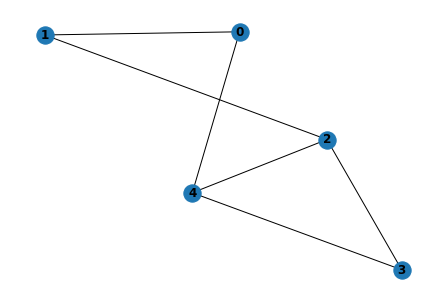

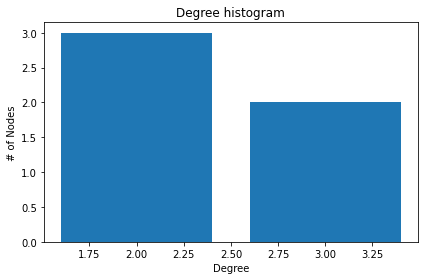

Tempo desconectado 0.9984276793780072
Intervalo de confiança (0.997650984684014, 0.9992043740720005)
Tempo com pelo menos um link falho 0.9997804880322656
Intervalo de confiança (0.9996665641261495, 0.9998944119383817)
Tempo conectado com pelo menos um link falho 0.0013528086542584073
Intervalo de confiança (0.0006440766789069493, 0.0020615406296098653)


In [86]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_B_n5_m6")
disconnected, fail_link, connected_fail = mm_one_b(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

#### Opção 2
- Faz o agendamento de todas as falhas antes da simulação começar
- Quando um link quebra já agendo seu reparo
- Quando um link é reparado já agendo uma nova falha para ele

In [59]:
def mm_one_b_alt(graph_matrix, lam, mu, log, visual_log):
  '''
    Recebe a matriz de adjacência retornado pelo MCMC; as taxas de reparo e falha e os logs
    Retorna as frações das métricas
  '''
  disconnected = [] # guardar o tempo que um par de nós não tem caminho em uma simulação
  fail_link = [] # guardar o tempo que tenho pelo menos um link falho em uma simulação
  connected_fail = [] # guardar o tempo que a rede está funcional, mas tem pelo menos um link quebrado em uma simulação

  links = get_edges(graph_matrix)
  total_time = 100

  # tipos de eventos
  fail = 'falha'
  repair = 'reparo'

  '''
  O evento é descrito da seguinte forma
  event = {
      'type': '', # tipo, se é falha ou reparo
      'time': 0 , # em que momento vai ocorrer
      'link': '', # em qual aresta (uma tupla)
  } # descrição do evento
  '''

  for i in range(rounds):
    # incialização das variáveis para um novo round
    waiting = [] # lista para guardar a fila da arestas quebradas, mas que não entraram na fila de eventos
                 # no caso da M/M/1 só posso ter um evento de reparo na fila de eventos
    booked_events = [] # lista que vai possuir dicionários
                       # eventos võa ser ordenados pela instante de tempo que devem ocorrer

    
    graph = nx.Graph(graph_matrix) # representa nossa rede, onde será feita alterações de falha e reparo
    time_passed = 0 # quanto tempo passou

    disconnected_time = 0 # somo o tempo que estiver desconectado
    fail_link_time = 0 # somo o tempo que estiver com pelo menos um link falho
    connected_fail_time = 0 # somo o tempo que estiver conectado, mas segue sendo uma rede funcional

    broken = [] # quais links estão quebrados
    working = links.copy() # no inicio temos todas os links funcionando
                           # cópia de links, para fazer alterações sem perder informação 

    # log
    log.info(f"Comecei a rodada {i}")

    # agendo todoas as falhas
    for link in working:
      time = np.random.exponential(1/lam)
      booked_events.append({'type': fail, 'time': time, 'link': link})

    booked_events = sorted(booked_events, key=lambda d: d['time'])

    while time_passed <= total_time:
      log.info(f"Lista de eventos agendados {booked_events}")
      log.info(f"Lista de espera de reparos {waiting}")
        
      current_event = booked_events[0]
      interval = current_event['time'] - time_passed # intervalo entre um evento anterior (time_passed) e novo (current_event['time'])

      # arrumar métricas
      if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
        disconnected_time = disconnected_time + interval
      if len(broken) > 0: # pelo menos um link falho
        fail_link_time = fail_link_time + interval 
      if nx.is_connected(graph) and len(broken) > 0:
        connected_fail_time = connected_fail_time + interval
      
      time_passed = current_event['time']

      if current_event['type'] == fail:
 
        # lido com a falha atual: de fato, quebrar o link (tirar do grafo, tirar da lista de funcionando...) e agendar o reparo

        # "quebrando o link"
        broken.append(current_event['link'])
        graph.remove_edge(current_event['link'][0], current_event['link'][1])
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} quebrou")

        # agendado o reparo do link que acabou de ser quebrado
        # por ser uma M/M/1 preciso checar se já não tenho alguém na fila para ser reparado
        # se tiver coloco na lista de waiting
        if len([element for element in booked_events if element['type'] == repair]) == 0: # não tenho repair nos eventos agendados, coloco
          time = current_event['time'] + 1/mu
          booked_events.append({'type': repair, 'time': time, 'link': current_event['link']})
          log.info(f"Como não tenho reparos agendados, agendo o reparo do link {current_event['link']} para o tempo {time}")
        else: 
          waiting.append(current_event['link']) # coloco em waiting a aresta que precisa ser arrumada
          log.info(f"Como tenho reparos agendados, agendo o reparo do link {current_event['link']} na última poisção da fila de espera {waiting}")


      else: # é um evento de reparo
        # conserto o link voltando ele a lista de funcionais e voltando com a aresta
        broken.remove(current_event['link'])
        graph.add_edge(current_event['link'][0], current_event['link'][1])
        log.info(f"Estamos no tempo {current_event['time']}, conforme o agendamento o link {current_event['link']} foi reparado")
        if len(waiting) > 0:  # se tiver alguém esperando seu lugar ao sol, pego a primeira aresta e agendo nos eventos
          time = current_event['time'] + 1/mu
          booked_events.append({'type': repair, 'time': time, 'link': waiting[0]})
          log.info(f"Como reparei uma aresta e tirei ela da lista de eventos, agendo o conserto da primeira aresta da fila, o link {waiting[0]} vai para fila e vai ocorrer no tempo {time}")
          waiting.pop(0)
        # marcando a quebra da aresta
        log.info(f"Assim agendo a próxima falha do {current_event['link']}") 
        time = current_event['time'] + np.random.exponential(1/lam)
        booked_events.append({'type': fail, 'time': time, 'link': current_event['link']})

      # quando o agendamento do reparo é feito, preciso tirar o evento da minha lista
      booked_events.pop(0)
      # ordeno a lista de eventos a partir do tempo
      booked_events = sorted(booked_events, key=lambda d: d['time'])
    

    # a cada round atualiza as listas com os resultados
    disconnected.append(disconnected_time/time_passed) # salvar a fração de cada rodada
    fail_link.append(fail_link_time/time_passed)
    connected_fail.append(connected_fail_time/time_passed)
      
  return disconnected, fail_link, connected_fail

Distância inicial 28.0
Distância Final 28.0


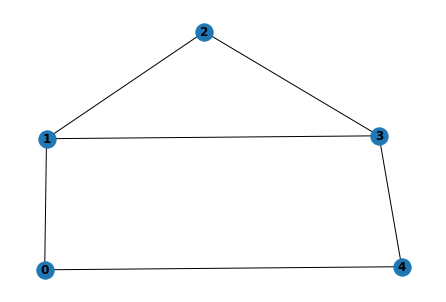

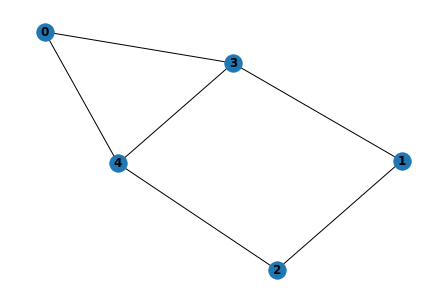

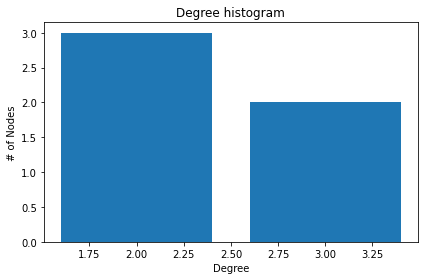

Tempo desconectado 0.9929003192143284
Intervalo de confiança (0.9893143995916271, 0.9964862388370297)
Tempo com pelo menos um link falho 0.9982809014180534
Intervalo de confiança (0.9972016902163893, 0.9993601126197175)
Tempo conectado com pelo menos um link falho 0.005380582203725024
Intervalo de confiança (0.0015628353060229238, 0.009198329101427124)


In [46]:
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_B_n5_m6")
disconnected, fail_link, connected_fail = mm_one_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 672.0
Distância Final 602.0


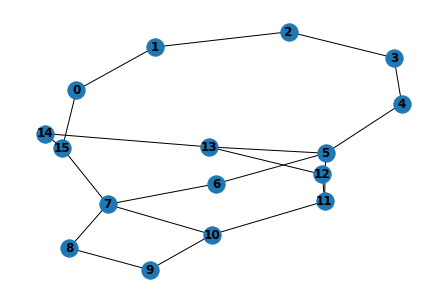

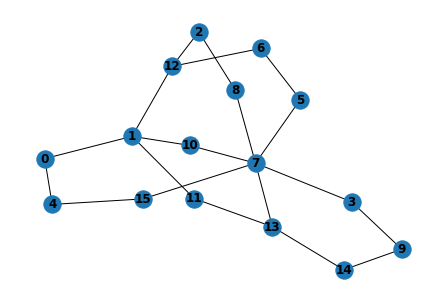

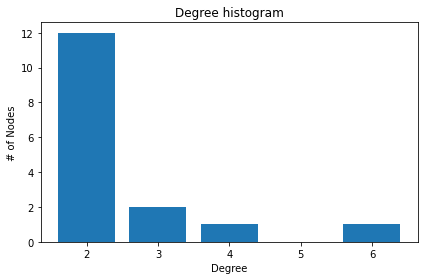

Tempo desconectado 0.9977668681942214
Intervalo de confiança (0.9970064762664642, 0.9985272601219787)
Tempo com pelo menos um link falho 0.9993714374959473
Intervalo de confiança (0.9990155862440097, 0.9997272887478849)
Tempo conectado com pelo menos um link falho 0.001604569301725881
Intervalo de confiança (0.0009284396153769113, 0.0022806989880748505)


In [45]:
n = 16
m = 20
logger, visual_logger = create_logger("n16_m20")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_B_n16_m20")
disconnected, fail_link, connected_fail = mm_one_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 1328.0
Distância Final 1074.0


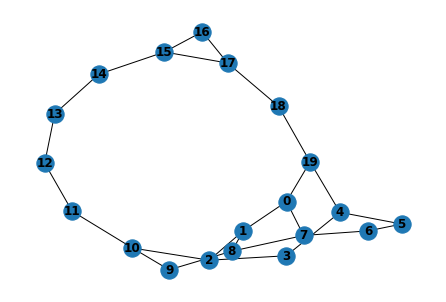

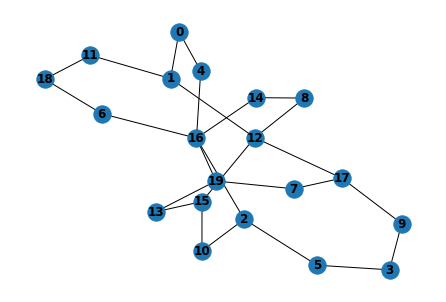

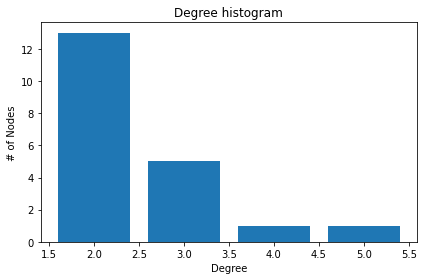

Tempo desconectado 0.9975502020205104
Intervalo de confiança (0.9969691317370425, 0.9981312723039782)
Tempo com pelo menos um link falho 0.999468487270059
Intervalo de confiança (0.9992531320837718, 0.9996838424563462)
Tempo conectado com pelo menos um link falho 0.0019182852495488278
Intervalo de confiança (0.0012524562330630223, 0.0025841142660346333)


In [42]:
n = 20
m = 25
logger, visual_logger = create_logger("n20_m25")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_B_n20_m25")
disconnected, fail_link, connected_fail = mm_one_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 5062.0
Distância Final 4700.0


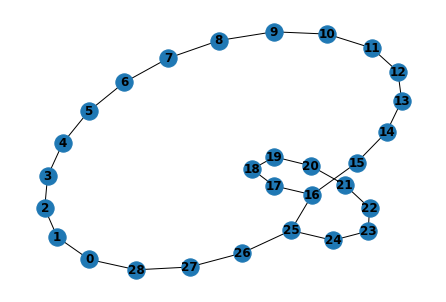

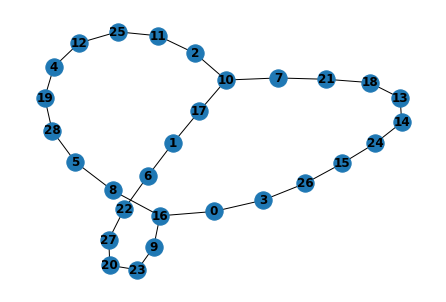

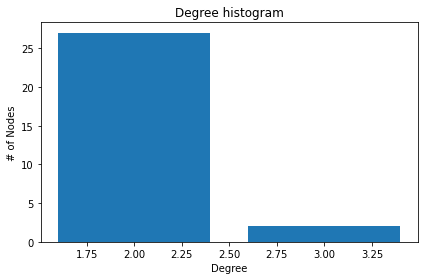

Tempo desconectado 0.998969477440615
Intervalo de confiança (0.9984934076002534, 0.9994455472809767)
Tempo com pelo menos um link falho 0.9993902395534648
Intervalo de confiança (0.999034151827566, 0.9997463272793636)
Tempo conectado com pelo menos um link falho 0.00042076211284991754
Intervalo de confiança (7.026268834682808e-05, 0.000771261537353007)


In [43]:
n = 29
m = 30
logger, visual_logger = create_logger("n29_m30")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_infbook_n29_m30")
disconnected, fail_link, connected_fail = mm_one_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

Distância inicial 3056.0
Distância Final 2896.0


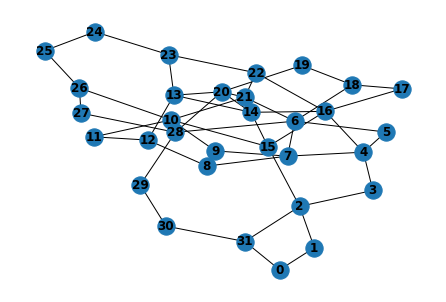

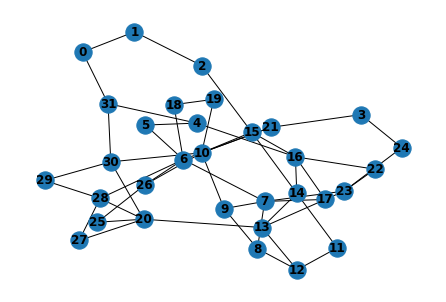

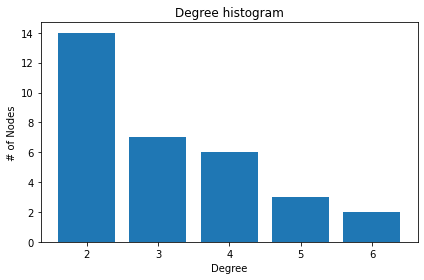

Tempo desconectado 0.9982686754896065
Intervalo de confiança (0.9976378115354619, 0.9988995394437511)
Tempo com pelo menos um link falho 0.9997561398599084
Intervalo de confiança (0.9996447329554022, 0.9998675467644146)
Tempo conectado com pelo menos um link falho 0.0014874643703017905
Intervalo de confiança (0.0009052802050158758, 0.002069648535587705)


In [40]:
n = 32
m = 50
logger, visual_logger = create_logger("n32_m50")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger_sim, visual_logger_sim = create_logger("sim_one_B_n32_m50")
disconnected, fail_link, connected_fail = mm_one_b_alt(result, lam, mu, logger_sim, visual_logger_sim)

print("Tempo desconectado", np.mean(disconnected))
print("Intervalo de confiança", confidence_interval(disconnected))
print("Tempo com pelo menos um link falho", np.mean(fail_link))
print("Intervalo de confiança", confidence_interval(fail_link))
print("Tempo conectado com pelo menos um link falho", np.mean(connected_fail))
print("Intervalo de confiança", confidence_interval(connected_fail))

# Resolução analítica 

In [ ]:
# 1. n = 5 e m = 6
n = 5
m = 6
logger, visual_logger = create_logger("n5_m6")
input, result, df_output = metropolis_hastings(n, m, logger, visual_logger)
logger.info(df_output)
input_graph = nx.from_numpy_matrix(input)
graph = nx.from_numpy_matrix(result)
logger.info("\n"+df_output.to_string())

### M/M/infinito

Distância inicial 28.0
Distância Final 28.0


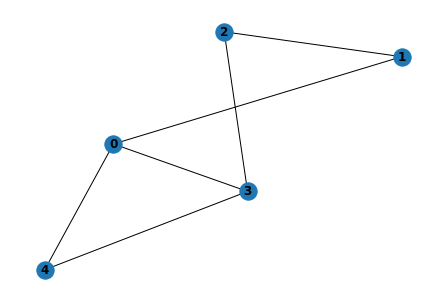

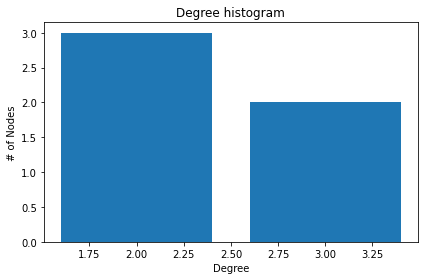

Quantidade de combinações de arestas falhadas caso a caso: [1, 6, 15, 20, 15, 6, 1]
Quantidade de possíveis estados, com todas as combinações de arestas falhadas: 64
[[ -6.   1.   1. ...   0.   0.   0.]
 [  1. -37.   1. ...   0.   1.   0.]
 [  1.   1. -37. ...   1.   0.   0.]
 ...
 [  0.   0.   1. ... -37.   1.   1.]
 [  0.   1.   0. ...   1. -37.   1.]
 [  0.   0.   0. ...   1.   1.  -6.]]
[0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]
[0.015625 0.015625 0.

In [ ]:
lam = 1
mu = 1
nodes = 5
edges = 6
logger, visual_logger = create_logger("n5_m6_analytical")
input, graph_for_analytical, df_output = metropolis_hastings(nodes, edges, logger, visual_logger)
# agora que já temos o grafo de um caso simples, como proposto, 
# é necessário saber todas as combinações possíveis de arestas que podem ter falhado
# para isso, vamos usar uma biblioteca para ajudar a montar as combinações de tuplas
# import itertools
propose_edges_by_case = list()
analytical_failed_edges = list()
# 0 das 6 arestas falharam, 1 das 6 arestas falharam, 2 das 6 arestas falharam
# 3 das 6 arestas falharam, 4 das 6 arestas falharam, 5 das 6 arestas falharam
# 6 das 6 arestas falharam
for i in range(edges+1):
  graph_edges = get_edges(graph_for_analytical)
  count = 0
  for proposal_edges in itertools.combinations(graph_edges, i):
    analytical_failed_edges.append(proposal_edges)
    count += 1
  propose_edges_by_case.append(count)
print(f'Quantidade de combinações de arestas falhadas caso a caso: {propose_edges_by_case}')
print(f'Quantidade de possíveis estados, com todas as combinações de arestas falhadas: {len(analytical_failed_edges)}')

analytical_failed_edges_size = len(analytical_failed_edges)
dimension = (analytical_failed_edges_size, analytical_failed_edges_size)
matrix_Q = np.zeros(dimension)

for current_state in analytical_failed_edges:
  # o set será útil para calcular a diferença entre dois estados
  current_state_set = set(current_state)
  c_state_index = analytical_failed_edges.index(current_state)
  for next_state in analytical_failed_edges:
    # o set será útil para calcular a diferença entre dois estados
    next_state_set = set(next_state)
    n_state_index = analytical_failed_edges.index(next_state)
    # a diagonal deve ser preenchida de forma a fazer a linha somar zero
    if c_state_index == n_state_index:
      continue
    # se a diferença entre o set do estado atual e o set do próximo estado for 1
    # então, é sinal de que um conserto ocorreu
    # porque há um estado a menos no estado seguinte
    if len(current_state_set - next_state_set) == 1:
      matrix_Q[c_state_index][n_state_index] = mu
    # se a diferença entre o set do próximo estado e o set do estado atual for 1
    # então, é sinal de que uma nova falha ocorreu
    # porque há um estado a mais no estado seguinte
    elif len(next_state_set - current_state_set) == 1:
      matrix_Q[c_state_index][n_state_index] = lam
    else:
      continue

# corrigir a diagonal
total_row_sum = np.sum(matrix_Q, axis=1).tolist()

for k in range(analytical_failed_edges_size):
  matrix_Q[k][k] = - total_row_sum[k]

print(matrix_Q)
from scipy.linalg import expm 
# print(expm(10*matrix_Q))
# print(expm(100*matrix_Q))
# print(expm(1000*matrix_Q))

# apenas para fins de comparação
p_t = expm(10*matrix_Q)[0].round(8)
p_t_100 = expm(100*matrix_Q)[0].round(8)
p_t_1000 = expm(1000*matrix_Q)[0].round(8)
print(p_t)
print(p_t_100)
print(p_t_1000)

In [ ]:
disconnected_time = 0
fail_link_time = 0
connected_fail_time = 0
for state in analytical_failed_edges:
    index = analytical_failed_edges.index(state)
    graph = nx.Graph(graph_for_analytical)
    for edge in state:
      graph.remove_edge(edge[0], edge[1])
    if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
      disconnected_time += p_t[index]
    if len(state) > 0: # pelo menos um link falho
      fail_link_time += p_t[index]
    if nx.is_connected(graph) and len(state) > 0:
      connected_fail_time += p_t[index]
print(f'Tempo desconectado: {disconnected_time}')
# recuperando o intervalo de confiança encontrado na simulação
print("Intervalo de confiança encontrado na simulação de tempo de reparo exponencial", confidence_interval(disconnected_inf_exp))
print("Intervalo de confiança encontrado na simulação de tempo de reparo determinístico", confidence_interval(disconnected_1_det))

print(f'Tempo com pelo menos um link falho: {fail_link_time}')
# recuperando o intervalo de confiança encontrado na simulação
print("Intervalo de confiança encontrado na simulação de tempo de reparo exponencial", confidence_interval(fail_link_inf_exp))
print("Intervalo de confiança encontrado na simulação de tempo de reparo determinístico", confidence_interval(fail_link_1_det))

print(f'Tempo conectado com pelo menos um link falho: {connected_fail_time}')
# recuperando o intervalo de confiança encontrado na simulação
print("Intervalo de confiança encontrado na simulação de tempo de reparo exponencial", confidence_interval(connected_fail_inf_exp))
print("Intervalo de confiança encontrado na simulação de tempo de reparo determinístico", confidence_interval(connected_fail_1_det))

Tempo desconectado: 0.71875
Intervalo de confiança encontrado na simulação de tempo de reparo exponencial (0.6979380608206437, 0.7393286373061355)
Intervalo de confiança encontrado na simulação de tempo de reparo determinístico (0.7101332298703321, 0.7419716474969612)
Tempo com pelo menos um link falho: 0.984375
Intervalo de confiança encontrado na simulação de tempo de reparo exponencial (0.977512058258741, 0.9900175275005608)
Intervalo de confiança encontrado na simulação de tempo de reparo determinístico (0.9836037835413124, 0.9887960988872918)
Tempo conectado com pelo menos um link falho: 0.265625
Intervalo de confiança encontrado na simulação de tempo de reparo exponencial (0.2485188604211267, 0.2817440272113958)
Intervalo de confiança encontrado na simulação de tempo de reparo determinístico (0.24448567118842532, 0.27580933387288575)


Com isso, é possível verificar que o resultado analítico está no intervalo de confiança calculado para a simulação feita.

### M/M/1

Distância inicial 28.0
Distância Final 28.0


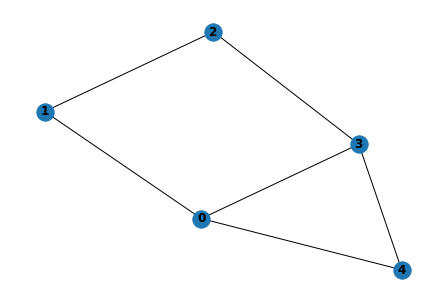

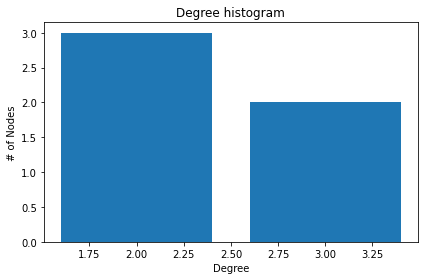

Quantidade de permutações de arestas falhadas caso a caso: [1, 6, 15, 20, 15, 6, 1, 1, 6, 30, 120, 360, 720, 720]
Quantidade de possíveis estados, com todas as permutações de arestas falhadas: 1957
[[-6.  1.  1. ...  0.  0.  0.]
 [ 1. -6.  0. ...  0.  0.  0.]
 [ 1.  0. -6. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
[0.00051149 0.00051141 0.00051141 ... 0.00051088 0.00051088 0.00051088]


In [ ]:
lam = 1
mu = 1
nodes = 5
edges = 6
logger, visual_logger = create_logger("n5_m6_analytical")
input, graph_for_analytical_2, df_output = metropolis_hastings(nodes, edges, logger, visual_logger)
# agora que já temos o grafo de um caso simples, como proposto, 
# é necessário saber todas as permutações possíveis de arestas que podem ter falhado
# para isso, vamos usar uma biblioteca para ajudar a montar as permutações de tuplas

# propose_edges_by_case = list()
analytical_failed_edges_2 = list()
# 0 das 6 arestas falharam, 1 das 6 arestas falharam, 2 das 6 arestas falharam
# 3 das 6 arestas falharam, 4 das 6 arestas falharam, 5 das 6 arestas falharam
# 6 das 6 arestas falharam
for i in range(edges+1):
  graph_edges_2 = get_edges(graph_for_analytical_2)
  count = 0
  for proposal_edges in itertools.permutations(graph_edges_2, i):
    analytical_failed_edges_2.append(proposal_edges)
    count += 1
  propose_edges_by_case.append(count)
print(f'Quantidade de permutações de arestas falhadas caso a caso: {propose_edges_by_case}')
print(f'Quantidade de possíveis estados, com todas as permutações de arestas falhadas: {len(analytical_failed_edges_2)}')

analytical_failed_edges_size_2 = len(analytical_failed_edges_2)
dimension = (analytical_failed_edges_size_2, analytical_failed_edges_size_2)
matrix_Q = np.zeros(dimension)

for current_state in analytical_failed_edges_2:
  # o set será útil para calcular a diferença entre dois estados
  current_state_list = list(current_state)
  c_state_index = analytical_failed_edges_2.index(current_state)
  for next_state in analytical_failed_edges_2:
    # o set será útil para calcular a diferença entre dois estados
    next_state_list = list(next_state)
    n_state_index = analytical_failed_edges_2.index(next_state)
    # a diagonal deve ser preenchida de forma a fazer a linha somar zero
    if c_state_index == n_state_index:
      continue
    # se há diferença entre o estado atual e o próximo, é um sinal de que ou 
    # um link foi consertado ou outro falhou
    if current_state_list != next_state_list:
      # conserto
      if len(current_state_list) > len(next_state_list) and current_state_list[:-1] == next_state_list:
        matrix_Q[c_state_index][n_state_index] = mu
      # falha  
      elif len(current_state_list) < len(next_state_list) and current_state_list == next_state_list[:-1]:
        matrix_Q[c_state_index][n_state_index] = lam
      else:
        continue

# corrigir a diagonal
total_row_sum = np.sum(matrix_Q, axis=1).tolist()

for k in range(analytical_failed_edges_size_2):
  matrix_Q[k][k] = - total_row_sum[k]

print(matrix_Q)
from scipy.linalg import expm 
# print(expm(10*matrix_Q))
# print(expm(100*matrix_Q))
# print(expm(1000*matrix_Q))

p_t_2 = expm(10*matrix_Q)[0].round(8)
print(p_t_2)

In [ ]:
# arrumar métricas
disconnected_time_2 = 0
fail_link_time_2 = 0
connected_fail_time_2 = 0
for state in analytical_failed_edges_2:
    index = analytical_failed_edges_2.index(state)
    graph = nx.Graph(graph_for_analytical_2)
    for edge in state:
      graph.remove_edge(edge[0], edge[1])
    if not nx.is_connected(graph): # está desconectado (não consigo caminho entre dois nós) 
      disconnected_time_2 += p_t_2[index]
    if len(state) > 0: # pelo menos um link falho
      fail_link_time_2 += p_t_2[index]
    if nx.is_connected(graph) and len(state) > 0:
      connected_fail_time_2 += p_t_2[index]
print(f'Tempo desconectado: {disconnected_time_2}')
print(f'Tempo com pelo menos um link falho: {fail_link_time_2}')
print(f'Tempo conectado com pelo menos um link falho: {connected_fail_time_2}')

Tempo desconectado: 0.9851732799999847
Tempo com pelo menos um link falho: 0.9994905599999845
Tempo conectado com pelo menos um link falho: 0.01431727999999999
